<!-- dom:TITLE: Machine Learning Methods for Events Classification in the AT-TPC -->
<!-- dom:AUTHOR: Author: Ceulemans Andreas, Fracassetti Stefano, Youssef Ahmed, Haoran Sun -->
<!-- Author: -->  

#  <span style="color:darkred"> Machine Learning Methods for Events Classification in AT-TPC</span> 

**Authors:** Fracassetti Stefano $^1$, Ceulemans Andreas $^1$, Youssef Ahmed $^1$, Morselli Luca $^2$, Sun Haoran$^3$ 

**$^1$** KU Leuven University, Belgium   
**$^2$** -     
**$^3$** -    

**Date:** August 31, 2020 


**Aknowledments:**   
A special thanks to the professor of the <a href="https://www.ectstar.eu/talents/talent-school-special-edition-2020/">Talent School 2020</a> for the course offered in Machine Learning.    
The course was given by the <a href="http://fribtheoryalliance.org/TALENT/">TALENT Initiative</a>, at <a href="https://www.ectstar.eu/">ECT* in Trento</a>.

    
**Credits:** 
- Fracassetti Stefano:
- Ceulemans Andreas:
- Youssef Ahmed:
- Morselli Luca:
- Sun Haoran:

# <span style="color:darkred">Description of the Project</span> 
(for better rendering, open the report locally with Jupyter Notebook, GitHub does not offer the best visualization)

## Task
The main objective of this project is to classify events (simulated data) aquired from the Active Target AT-TPC, as being "beam" or "reaction" events. The idea is to implement a "software trigger" which would be able to effectively select only relevant data to save on disk for future analysis. The project task is described in the <a href="https://github.com/fracassetti-stf/AT_Project/blob/master/AT_Project_Specifications.pdf">Project Specifications</a>.

We will apply the ML techiques learned during the <a href="https://www.ectstar.eu/talents/talent-school-special-edition-2020/">Talent School 2020</a> , in order to analyse the data and reach the best performance possible.<br>


## Tabel of Content:

#### Data Import
In this section we deal with the data import, and we perform the first basic operations on the data.
- Data Import: from HDF5 format into python
- Data Storage: nested List
- Labelling of the data (supervised learning): beam or Reaction?
- Cleaning of the data: remove all empty events.
- Data Slitting: Train, Validation, and Test through Scikit-learn

#### Data Exploration
In this section we will visualize the data, to get a first insight on the data we are analysing. We then extract event features that we consider meaningful for classification task, and we visualize them as well.
 
- Data Visualization: 3D plot, and 2D Pad Plane projections.
- Event Features: calculating event features to be used for classification
- Visualizing the Features (and the Outliers)
- Scaling the Data

#### Machine Learning
In this section we propose various approaches to tackle to problem, and we show the results obtained with each methods.

Most simple approaches:
- Logistic Regression  
- Random Forest (with Grid Search)    
- Dense Neural Networks DNN
- K-Means (varying cluster number)    
- Support Vector Machine SVM


- Convolutional Neural Network
    - Generating Images
    - CNN with a costumized model, and VGG16
    
    
- Dimensionality Reduction Algorithms
    - PCA
    - t-SNE
    - AutoEncoder
    

### Common Import

In [1]:
import os
import sys
import math

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
    

import h5py

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
                             matthews_corrcoef, roc_curve, roc_auc_score, classification_report)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.applications import vgg16
from tensorflow.keras import backend as K


from helper_functions import *

# Aliases
layers = tf.keras.layers
# Fixing seed for reproducibility
np.random.seed(42)

C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

# <span style="color:darkred">Data Import</span> 

### Data Format
Data are saved in <a href="https://github.com/fracassetti-stf/AT_Project/blob/master/AT_Project_Specifications.pdf">DataFiles/Mg22_alphaalpha_digiSim.h5</a>, which contains 2000 simulated events: even numbers are "beam" events, while odd numbers are "reaction" event. Each event is constitued by a point cloud of the active pads for that event. The number of hit pads may vary for each event, ranging from around 20, up to a few hundred.  

Each hit pad is associated with a 4-tuple (x, y, z, t, A): 
- (x,y) are the position of the hit pad on the detector plane, 
- z is the coordinare associated to the beam axis,
- t is the time associated with the pad signal, and
- A is the charge deposited on the pad.<br> 

The time information is unnecessary since data already contains the z coordinate thanks to a pre-processing phase. There is also an extra column of zeros, which do not carry any meaningful information.<br>


### Let's have a look at the data file 

####  HDF5 file Format
First we load the data, which are stored as a hdf5 file, a (Hierarchical Data File) format designed to store and organize large amounts of data. The HDF5 file structure includes only two types of objects:
- Datasets: multidimensional arrays of a homogenous type
- Groups: container structures, that can hold Datasets or other groups

What's important to remember is that when opening a HDF5 in python through the command:
```
hf = f = h5py.File('./path/to/file', 'r')
```
we are creating this file objecct in which "Groups work like Dictionaries, and DataSets work like NumPy arrays", it is possible to check the datasets/groups contained in the file by typing:
``` 
list(hf.keys())
```

####  Mg22_alphaalpha_digiSim.h5
In this file, there were no groups, but 2000 datasets each one corresponding to an event, named "Event_[#]". Each event/key is a 2D-array which contains 6 columns and multiple rows (hit pads).

- We first want to give a table view of the data by printing the first event as example:<br>
```
pd.DataFrame(hf.["Event_[i]"])
```

- We then want to visualise the lenght of the data. How many events are we dealing with?<br>
```
len(list(hf.keys()))
```
Here we can se that the there are 2000 events.
<br/><br/>
    
- It is interesting to print a few events type to see how many pads were written per event:<br>
```
list(hf.keys())
hf["Event_[i]"]
```   
We can see now that the keys have the name "Event_[#]", we can see the shape of the event.
It is possible to notice that the reaction event have consistently more hit pads in respect to the beam events.
<br/><br/>
- Eventually we will plot the entire set of information for an event to see the actual structre:<br>
```
hf["Event_[0]"].dtype
hf["Event_[0]"][:]    
```

### Loading the Data
We will first load the datafile, and visualize the first event: Event_[0] 

In [2]:
local_data = './DataFiles/Mg22_alphaalpha_digiSim.h5'
hf = h5py.File(local_data, 'r')


#Table view of an event
Event_0=pd.DataFrame(hf["Event_[0]"][:])
print("DataSet: Mg22_alphaalpha_digiSim.h5")
print("Event Number: 0")
print("Label: Beam")
display(Event_0)

DataSet: Mg22_alphaalpha_digiSim.h5
Event Number: 0
Label: Beam


,x,y,z,t,A,trackID
0,-2.454130,1.450752,834.0,417,6733.605773,0
1,-0.000013,2.799905,834.0,417,12585.463255,0
2,-2.454130,-1.450752,834.0,417,1705.208085,0
3,2.454133,-1.450752,900.0,450,3778.845219,0
4,-0.000013,-2.799905,900.0,450,11368.678344,0
5,2.454133,1.450752,962.0,481,3210.764796,0
6,4.908251,-5.701409,964.0,482,44.570651,0
7,2.454104,7.050561,966.0,483,21.112801,0
8,-2.454131,-7.050561,984.0,492,19.055387,0
9,-4.908247,5.701409,986.0,493,19.747327,0


### Data Storage

####  Nested List
This seems to be the most suited structure to handle these data, where every element of the list is an event. Each dataset have different lenght, and lists are able to handle this without problem.
In the next cell, we import the data in a list.
We can show each element of a list, which correspond to a single event of the hdf5 file.  
    
We could check that these two operations give the same result:
```
    print(hf["Event_[0]"][:])
    print(DataList[0])
```

    
####  Pandas DataFrame/Series, Numpy Array ?
These structure do not seem to respond nicely to our needs. 
    
- **Pandas DataFrame** are 2D structure of fixed lenght. In our case, we would need 3D array, where one variable has a variable lenght. Providing that we could stored NaN (or predefined value) where data is missing, there is still the proble we can not store all the DataSet in a DataFrame structure type. However it is possible to store each event in a single and different DataFrace structure. There is no advantage to do this in respect to a list in the end, so we still opt on nested list.<br/><br/>
    
- **Pandas Series** are 1D arrays capable of holding data of any type (integer, string, float, python objects, etc.). The axis labels are collectively called index. Not adapted for our data.<br/><br/>   
    
- **Numpy Array** are a grid of values, all of the same type, and is indexed by a tuple of nonnegative integers. The number of dimensions is the rank of the array; the shape of an array is a tuple of integers giving the size of the array along each dimension. This structure is not adapt to host our data, since they required again a fixed dimension. In principle it would be possible leaving (or predefined value) where data are missing. This method is inefficient. As for DataFrame, it would be possible to use this struture to store each event in a single and different Numpy Array.

Anyway, one has different possibilities after extracting the relevant features, from the 2D matrix. It is possible in that case to use Numpy Array, or DataFrame, or Lists again. 

### Labeling and cleaning

####  Labeling

The next step is to label and clean the data.
We know from the task description that the data come labeled (supervised learnig):
- Reacion Event (Label=1)
- Beam Event (Label=0)  
    
Note that assigning 1 or 0 is a matter of choice, it is possible to do the opposite.
This choice reflect the idea that a reaction event is to keep, while a beam event must be rejected, so associated to a nul value.

####  Cleaning
   
This phase is rather simple, the events do no have missing values. We only noticed that we deal with "empty" events. Event number (384, 430,484,914,1204 (numbers correspond to keys)) do not contain any value, so must be discarded.
    
    
All the operation mention above are perfromed through the function load_data, defined in helper_functions.py

In [3]:
DataList, Labels = load_data(hf)
hf.close()

Dataset contains 2000 events
Data contains 5 empty events, of indexes: [384, 430, 484, 914, 1204]

Dataset contains 1995 non-empty events:
995 Beam Events, and 1000 Reaction Events



The DataSet we are going to analyse is formed by 1995 non-empty events. The histgram below shows length of the remaining non-empty events.

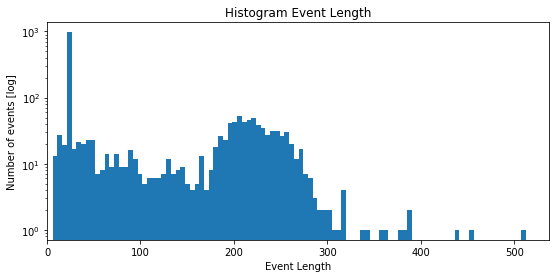

In [4]:
EventLength = []
#Histgram for the distribution of the length of events
for i in range(len(DataList)):
    EventLength.append(len(DataList[i]))
EventLength = np.asarray(EventLength)

# Plot length distribution
fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(EventLength, bins = 100)
ax.set_title('Histogram Event Length')
ax.set_xlabel("Event Length")
ax.set_xlim(0,)
ax.set_yscale('log')
ax.set_ylabel("Number of events [log]")
plt.show()

### Slpitting the data

In every ML algorithm we have to first split the data in training, validation and (possibly) test. 
- **Training Data** will be used to feed the algorithm and to train it. 
    
    
- **Validation Data** are going to be used in order to see how our algorithm performs on data which has not be used to train it.<br/> Anyway, validation data would be useful to tune our algorithm, e.g. deciding when to stop the training, and adjust some parameters.
    
    
- **Test Data** are meant to test the algorithm on completely newly data, such as they were a different dataset.
    
Usually the original data are divided for 90% - 70% into training and the rest for validation and testing.
    
Sklearn provides a function: "train_test_split" which makes this operation very handy. This function would split the data in two subsets, in a fraction which is possible to specify through the function options. Applying twice this function we can reach our goal. 
    
In order to save memory and computation time (because we care about our computers), we do not load the function with actually features and labels, as more obvious choice, but simply with a list of index, which would result in the creation of indexes subsets, wich can be used to separate the data.   
The outcome of this operation can be viewed as shuffling the indexes in three subsets, of desider lenght.

In [5]:
x_idx = np.arange(len(DataList))


# Splitting in train+validation (90% in total), and test (10%)
trainval_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.10)
# Splitting the remaining part (90% of the original DataSet): Training (90%) and Validation (10%)
train_idx, val_idx, not_used3, not_used4 = train_test_split(trainval_idx, trainval_idx, test_size = 0.10)


print("Dataset was slitted in train, validation, and test:")
print(str(len(train_idx)) + " training events,")
print(str(len(val_idx)) + "  validation events, and")
print(str(len(test_idx)) + "  test events")

Dataset was slitted in train, validation, and test:
1615 training events,
180  validation events, and
200  test events


# <span style="color:darkred">Data Exploration</span> 

### Visualizing the data: let's get some insight!
Now that the data have been prepared, we would like to have a first look at the data.  
We plot the first 12 events:
- 3D plots (x,y,z)
- 2D projections (x,y) - the event as seen from the plane surface.

### 3D Visualization (x, y, z)

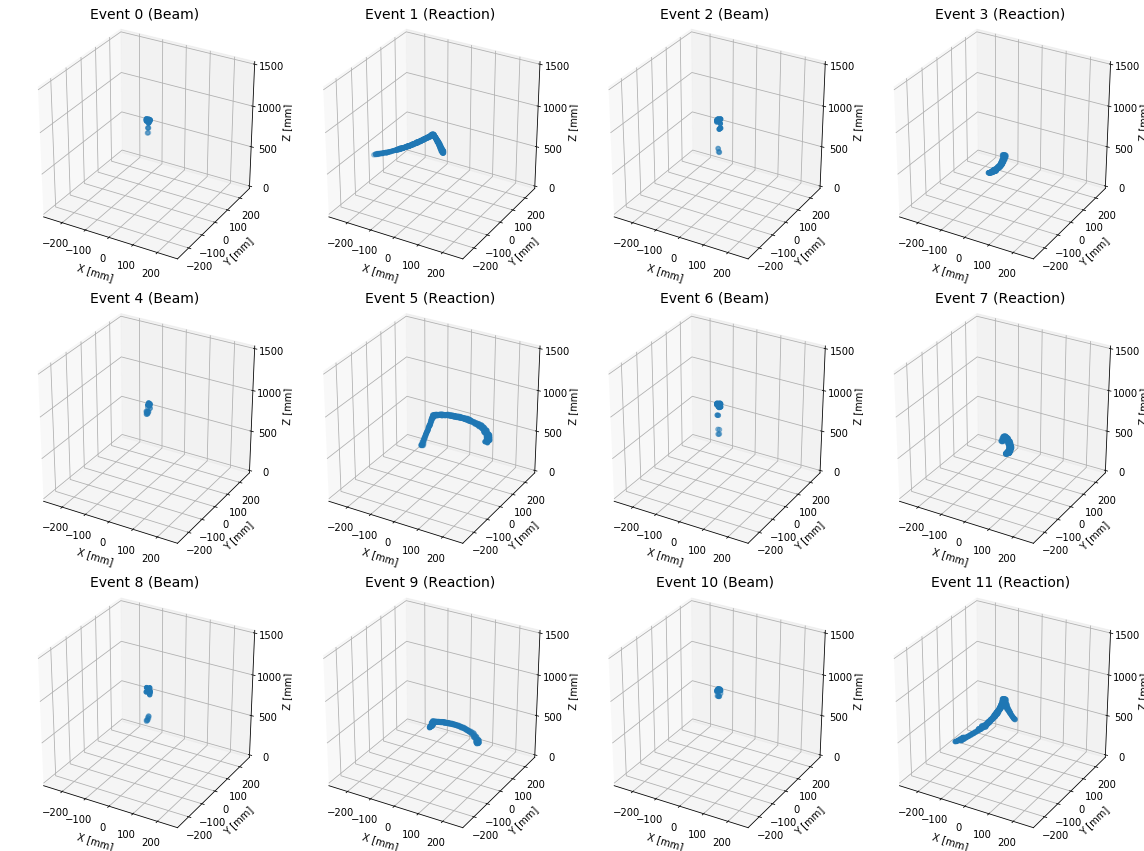

In [6]:
plot_3d_events(DataList,Labels)

### Pad Plane Projections (x, y)
For this events the gray scale correspond to the charge deposited on the respctive pad (in a logarithmic scale).

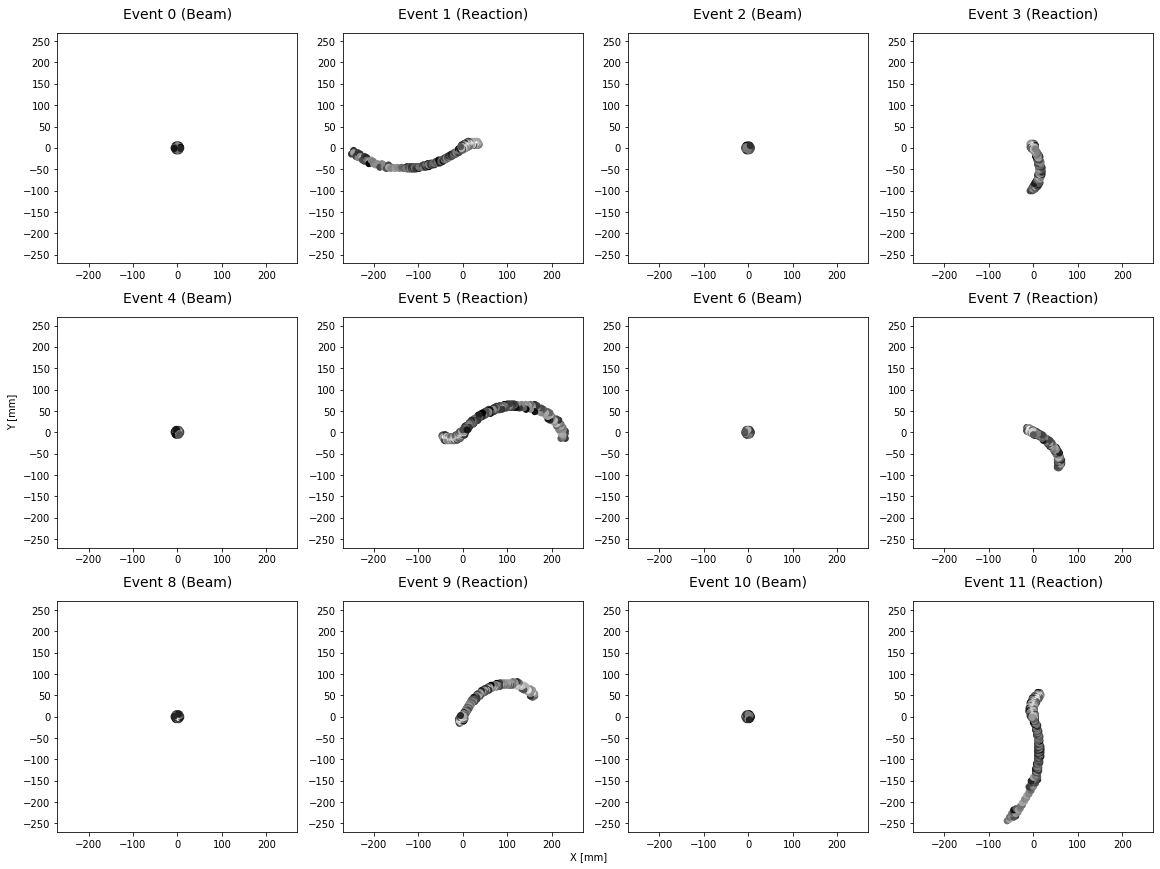

In [7]:
plot_2d_events(DataList, Labels)

###  Selecting Features

Which data do we feed into the algorithm? We cannot feed all the 2D martix containing all the information for each event, we need to see a design matrix, and select relevant features for each events. Furthermore, a non-fixed lenght of the 2D matrix would create additonal challenges in how to manage those data.

So, we need to extract a number of features for each event, based on the information available for that event. Which characteristcs would help us differentiating events based on the fact that we are dealing with a "beam" rather than a "reaction" event? 

 

#### Features

The question can be answered having a look to the different events: in the plots above (two previous cells), it is quite clear that the number of pads plays a crucial role. Other features are not obvious, and need a bit of analysis. Most of the times, beven by eye we can somehow differentiatig the events to be labelled as "reaction" since they present a more definite (and almost straight?) track.  

We thought some relevant characteristics could be the average value of x,y and z, or rather a weighted avereage, based on the charge deposited, and their standard deviations. Also, the total deposited charge can be an interesting quantity. We also defined the quatity FCS (Fraction of Close Pads) which is the ratio of pads inside a radius of 10cm, respect the total number of fired pads.

Here a list of the quantity we calculated through the function calc_features:
```
# Every quantity is computed for each single event

MeanXPerEvent         # Average X value 
MeanYPerEvent         # Average Y value 
MeanZPerEvent         # Average Z value

MeanWeightedXPerEvent # Charge weighted average X 
MeanWeightedYPerEvent # Charge weighted average Y
MeanWeightedZPerEvent # Charge weighted average Z

StDevXPerEvent        # Standard deviation of X 
StDevYPerEvent        # Standard deviation of Y
StDevZPerEvent        # Standard deviation of Z

SumAPerEvent          # Total deposited charge
PadsPerEvent          # Number of pads fired
FracClosePtsPerEvent  # Fraction of pads inside a circle of radius 10cm to the z-axis
```


In [8]:
# Computing Features
(MeanXPerEvent, MeanYPerEvent, MeanZPerEvent, SumAPerEvent, 
PadsPerEvent, MeanWeightedXPerEvent, MeanWeightedYPerEvent, 
StDevXPerEvent, StDevYPerEvent, StDevZPerEvent,FracClosePtsPerEvent) = calc_features(DataList)


### Visualizing Features 

In order to visualize the features extracted, and deciding whether are well suited for our task, we will them show in the plots below. We immediately notice that some of the extracted features will be more relevant, such as the number of hit pads, the total charge deoposited, and the mean Z, while others, like mean x or mean y are not extremely interesting. 

In [9]:
# Some definition before plotting 
train_r_idx, train_b_idx = train_split(train_idx, Labels)
r_color = 'blue'
b_color = 'black'

#### Histograms
- Active Pads per event, 
- Total Deposited Charge per event, and
- Fraction of pads inside a radius of 10cm

Histograms:


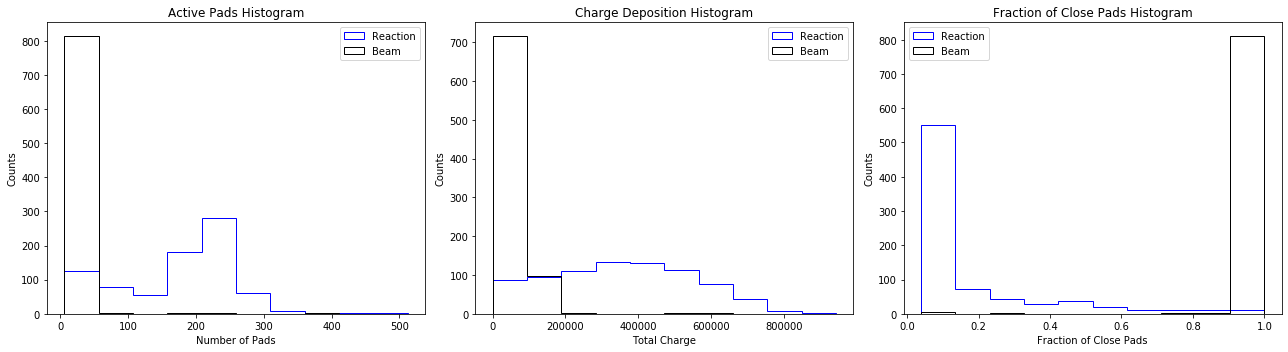

In [10]:
print("Histograms:")
plot_features_hist(train_r_idx, r_color, train_b_idx, b_color, PadsPerEvent, SumAPerEvent, FracClosePtsPerEvent)

TO BE COMPLETED
- *Active Pads and Charge Deposition Histogram*, it is clear that the reaction events tend to have a lower amount of active pads, as well a much higher charge deposited. This variables alone can already separate the two type of event quite well. The reason is that beam events comes at high energy, and leave an intense track, while reaction scattering transfer lower energy to its components.
- *Fraction of Close Pads*, this variable represents the fraction of active pads confined in a radius of 10cm, in relation to all the pads fired for that event. It is possible to notice that for the reaction events this variable is close to 1. Beam events have a higher dispension in the three x,y (and z) directions (see also stdev plots).

#### Scatter Plots
2D Scatter Plots, as combination of these quantity:
- Mean X, Y, Z per event
- Standard Deviation X, Y, Z per event

Scatter Plots: X, Y, Z


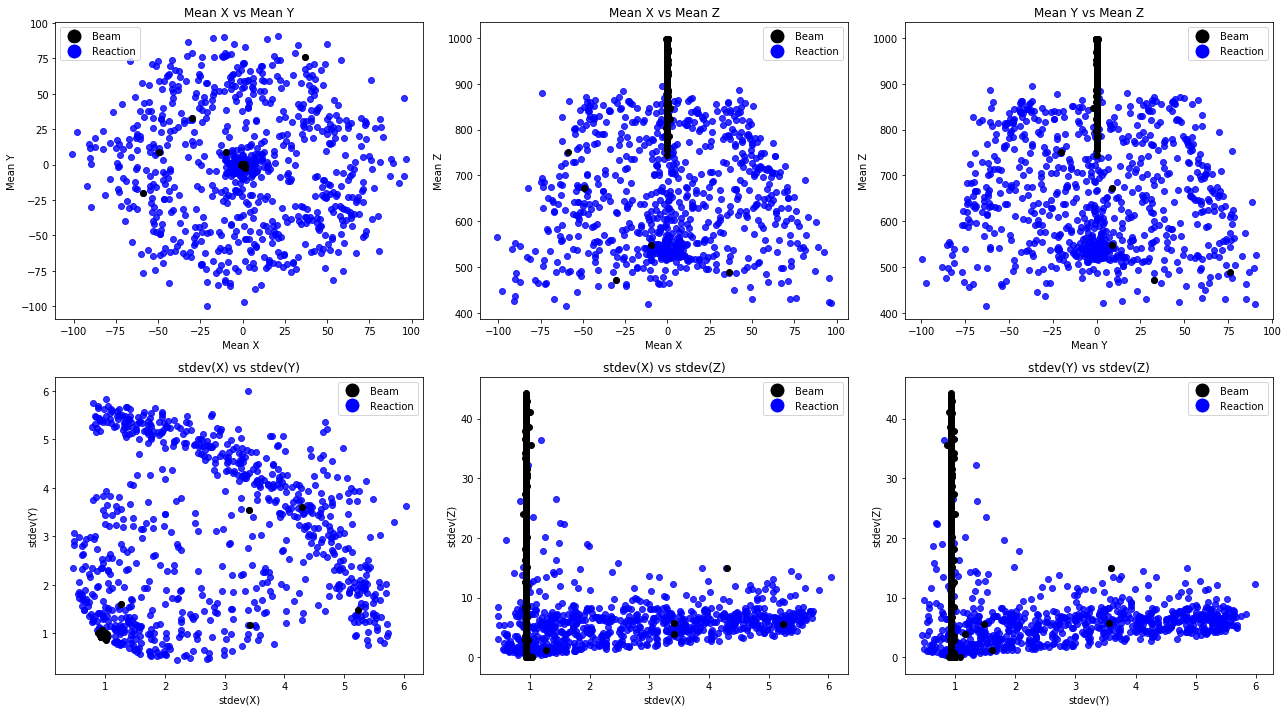

In [11]:
print("Scatter Plots: X, Y, Z")
plot_features_scatter(train_r_idx, r_color, train_b_idx, b_color, MeanXPerEvent, MeanYPerEvent, MeanZPerEvent, StDevXPerEvent, StDevYPerEvent, StDevZPerEvent)

TO BE COMPLETED
- *Mean X,Y,Z*, from (X,Y) plot we can notice that reaction evetns tend to lay in the conter of the plot, while beam events are scattered with a certain dispersion. Plots (X,Z) and (Y,Z) are more interesting, since we can notice how rection events have generally an higher mean Z. 
- stdev X,Y,Z, beam events have generally a larger spread in X and Y direction, reaction events the opposite:  higher z dispersion, but much smaller stdev in x and y. 

#### Scatter Plots (with most relevant features)
- stdev(Z) vs FCP
- Active Pads vs Total Deposited Charge

Scatter Plots: Other Combinations


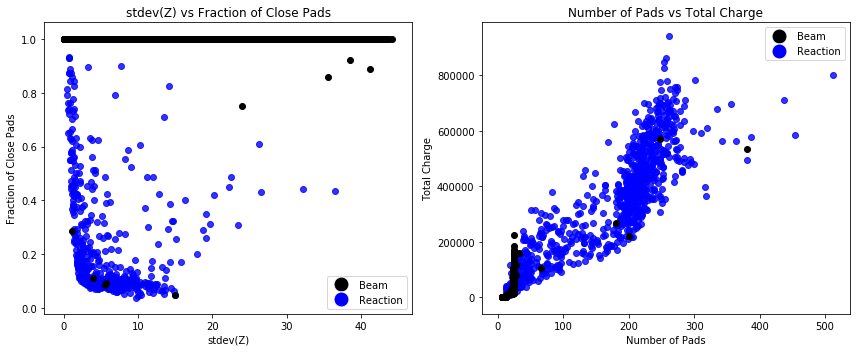

In [12]:
print("Scatter Plots: Other Combinations")
plot_features_scatter2(train_r_idx, r_color, train_b_idx, b_color, StDevZPerEvent, FracClosePtsPerEvent, PadsPerEvent, SumAPerEvent)    

TO BE COMPLETED
- FCP and stdev(z), 
- Total Charge and #pads, Reaction evetns are localized in the region of low amount of active pads, and low charge. Beam event are spread all around the region, with a positive correlation between the two variable.

### Visualizing the Outliers
In the plots above there are some outliers: events which label may be mistaken, when looking to the features extracted. We want to plot this events, and see how they look like.

These outliers are beam events, which look really like reaction events.

Outliers using current criteria:
stdev(X) >  3  cm      : [ 280  499 1098 1711]
Number of Pads >  100  : [ 280  499 1098 1711]
FCP <  0.4             : [ 280  499 1098 1237 1711]
Outliers that satisfy at least one criterion: [ 280  499 1098 1237 1711]


>>>>>>>>>>>>>>>>>>>>>>>>>>> Outliers:  280 <<<<<<<<<<<<<<<<<<<<<<<<<<<
stdev(X)       :  3.411
Number of Pads :  200
FCP            :  9.50%


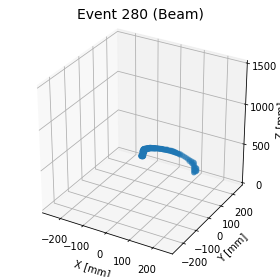

>>>>>>>>>>>>>>>>>>>>>>>>>>> Outliers:  499 <<<<<<<<<<<<<<<<<<<<<<<<<<<
stdev(X)       :  4.298
Number of Pads :  380
FCP            :  5.00%


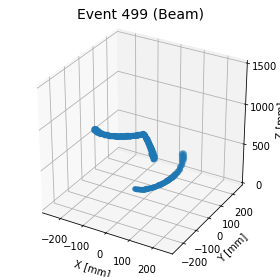

>>>>>>>>>>>>>>>>>>>>>>>>>>> Outliers:  1098 <<<<<<<<<<<<<<<<<<<<<<<<<<<
stdev(X)       :  3.418
Number of Pads :  180
FCP            :  11.11%


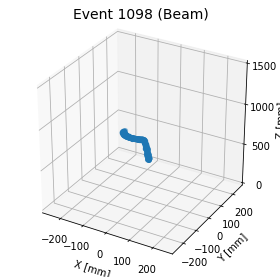

>>>>>>>>>>>>>>>>>>>>>>>>>>> Outliers:  1237 <<<<<<<<<<<<<<<<<<<<<<<<<<<
stdev(X)       :  1.259
Number of Pads :  66
FCP            :  28.79%


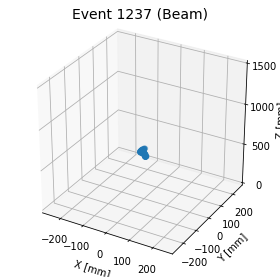

>>>>>>>>>>>>>>>>>>>>>>>>>>> Outliers:  1711 <<<<<<<<<<<<<<<<<<<<<<<<<<<
stdev(X)       :  5.235
Number of Pads :  247
FCP            :  8.50%


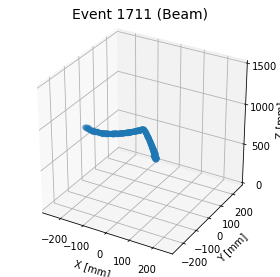

In [13]:
# Outliers Beam events characteristics
plot_beam_outliers(DataList, Labels, train_b_idx, StDevXPerEvent, 3, PadsPerEvent, 100,  FracClosePtsPerEvent, 0.4)

### Design Matrix


We could see through the plots that some of the features are clearly useful to classify beam/reaction events. The most meaningful features are used to create a design matrix (also called feature matrix). We call this X, one may add other features, making the matrix more complex, aiming for better results.

In [14]:
X = np.zeros((len(DataList),5)) # Design Matrix with 5 features

# Filling the matrix
for i in range(len(DataList)):
    X[i][0] = MeanZPerEvent[i]
    X[i][1] = StDevXPerEvent[i]
    X[i][2] = FracClosePtsPerEvent[i]
    X[i][3] = SumAPerEvent[i]
    X[i][4] = PadsPerEvent[i]
    # not used 
    #xSimple[i][0] = MeanXPerEvent[i]
    #xSimple[i][1] = MeanYPerEvent[i]
    #xSimple[i][1] = StDevYPerEvent[i]
    #xSimple[i][5] = StDevZPerEvent[i]

# Dividing entries in train, val and test
X_train =      X[train_idx][:]
X_val =        X[val_idx][:]
X_test =       X[test_idx][:]
Labels_train = Labels[train_idx]
Labels_val =   Labels[val_idx]
Labels_test =  Labels[test_idx]

# Converting to DataFrame for better visualization, and for possible later use
X_df= pd.DataFrame(X)
print("Design Matrix X:")
feature_names = ['Mean Z','stdev(X)','FCP','Total Q','Pads']
X_df.columns = feature_names
label_names = ['Beam','Reaction']
display(X_df)

Design Matrix X:


,Mean Z,stdev(X),FCP,Total Q,Pads
0,961.083333,0.930198,1.000000,41292.864135,24.0
1,661.897436,5.692321,0.097436,322786.822798,195.0
2,877.083333,0.930198,1.000000,89094.206758,24.0
3,529.016129,0.646942,0.153226,168967.813590,124.0
4,938.916667,0.930198,1.000000,34598.337410,24.0
...,...,...,...,...,...
1990,485.930818,3.872534,0.062893,364154.705449,318.0
1991,817.750000,0.930198,1.000000,117215.746684,24.0
1992,526.930233,0.782013,0.418605,37851.885998,43.0
1993,940.083333,0.930198,1.000000,45542.970478,24.0


### Scaling the data 
Scaling (or normalize) the data can improve the model performance quite significantly in some cases. Scikit-learn has a few different methods, of which the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler) is used below. This scaler transforms each feature to have mean zero and unit variance. 
<a id='StandardScaler'></a>

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

# Using the standardscaler
X_train_stdsc = scaler.transform(X_train)
X_val_stdsc = scaler.transform(X_val)
X_test_stdsc = scaler.transform(X_test)

#  <span style="color:darkred">Machine Learning Algorithms</span> 

After loading the data and selecting the features to use, the actual machine learning can start.
To achieve the best results on the classification task, 
different models will be tested and their performance will be discussed.

#  <span style="color:darkred">Logistic regression</span>

Logistic regression is a widely used method for classification. 
It uses a sigmoid function to calculate the probability for an event to belong to a certain class.
The training procedure is used to optimize the cost function in terms of the parameters $\beta$ of the sigmoid function. In our case the standard implementation of [scikit-learn](https://scikit-learn.org/stable/index.html) is used. Remark that this implementation uses L2 regularization by default. <br>
The print_model_performance funtion is located in the helper functions file. It will be used to print the performance 
characteristics and display the confusion matrix for each model. This is done for both training and validation set separately.


###  The logistic regression: Unscaled data
This time, we will evaluate the model first on unscaled features, and later on the scaled ones. We want to show the advantage of using one of the scaling techniques.

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 95.79%
Precision : 99.32%
Recall    : 92.10%
F1-score  : 0.9557
MCC       : 0.9181


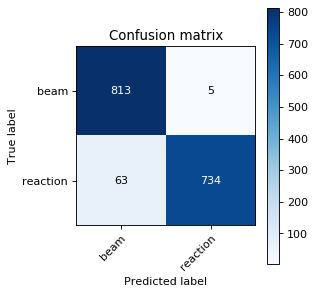


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 96.67%
Precision : 98.86%
Recall    : 94.57%
F1-score  : 0.9667
MCC       : 0.9343


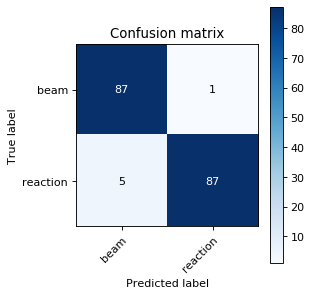

In [16]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, Labels_train) # provide Design matrix and labels

LR0_pred_train = logreg.predict(X_train)
LR0_pred_val = logreg.predict(X_val)

# Function to output model performances
print_model_performance(Labels_train,LR0_pred_train,"Training")
print_model_performance(Labels_val,LR0_pred_val,"Validation")

Not a bad start for our analysis! With an accuracy greater than 95% for both training and validation sets it classifies  quite well. It however seems to classify a significant amount of reaction events as beam events.

### The logistic regression: Scaled data
The logistic regression model is repeated, but the features are now scaled, as shown in the [StandardScaler](#StandardScaler) cell above.

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.69%
Precision : 99.38%
Recall    : 100.00%
F1-score  : 0.9969
MCC       : 0.9938


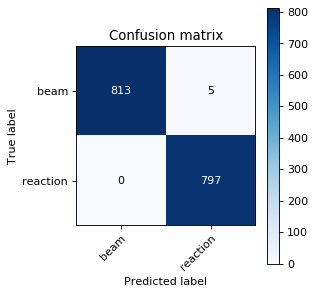


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 0.9946
MCC       : 0.9889


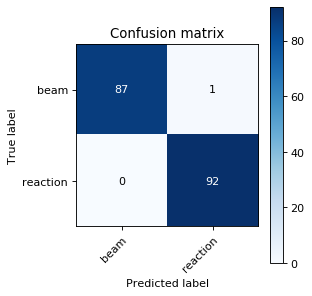

In [17]:
logreg2 = LogisticRegression()
logreg2.fit(X_train_stdsc, Labels_train)

LR_pred_train = logreg2.predict(X_train_stdsc)
LR_pred_val = logreg2.predict(X_val_stdsc)

print_model_performance(Labels_train,LR_pred_train,"Training")
print_model_performance(Labels_val,LR_pred_val,"Validation")

Comparing to previous results, the improvement is clear. The accuracy increased to over 99% 
on both training and validation data. This shows it is well worth looking into scaling the features of your dataset.
For the remainder of this report all models will be trained using the scaled features.

#  <span style="color:darkred">Random Forest</span>

The random forest method combines the output of a number of decision trees to make predictions. Each decision tree 
uses nodes with if-then-else structured conditions on the features that end up in a classification. 

### Decision trees: an example
Decision trees are a type of model used for both classification and regression. Trees answer sequential yes-no questions which send us down a certain route of the tree depending on the given answers . The model behaves with “if this than that” conditions ultimately yielding a specific prediction. You can see a simple tree displayed below.

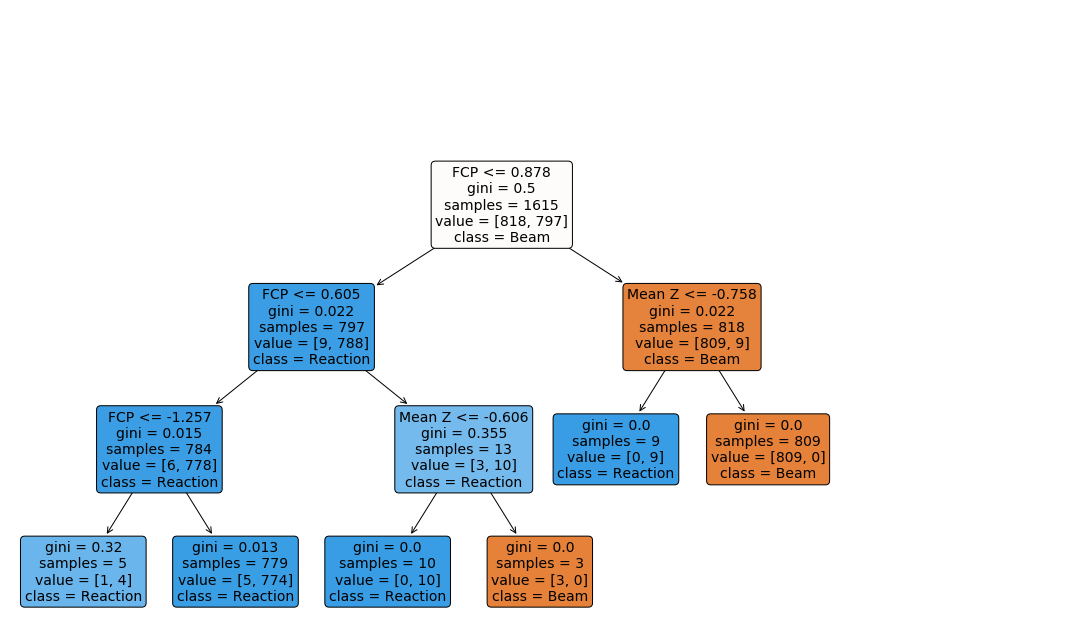

In [18]:
from sklearn import tree
DT = tree.DecisionTreeClassifier(max_depth=3)
DT = DT.fit(X_train_stdsc, Labels_train)

# Better visualization of the tree
fig, ax = plt.subplots(figsize=(15, 9))
tree.plot_tree(DT, fontsize=14, filled = True, rounded = True, feature_names = feature_names, class_names = label_names)

fig.tight_layout()
plt.show()

This simple graph shows the steps taken by the decision tree. Each cell contains a condition on one of the features (remember that these are scaled), for example the top cell asks whether 'FCP<=0.863'. If true the left path is followed, else the right path is taken. The 'value' indicates how many events of each type (\[beam,reaction\]) remain and 'class' shows the chosen classification at each step. The tree also shows the gini impurity which is used internally for deciding on the conditions of each cell.

###  From decision tree to random forest  
A random forest is a collection of decision trees whose results are aggregated into one final result. Therefore random forest is an ensemble method. By averaging over independant results the variance of the ensemble method is lowered, leading to better results. For more information about ensemble methods, see the [scikit-learn page on ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html).


Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.88%
Precision : 99.75%
Recall    : 100.00%
F1-score  : 0.9987
MCC       : 0.9975


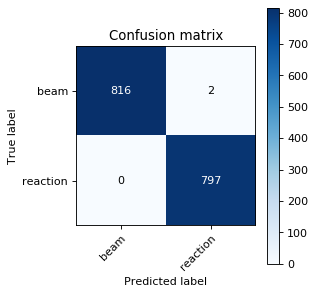


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 0.9946
MCC       : 0.9889


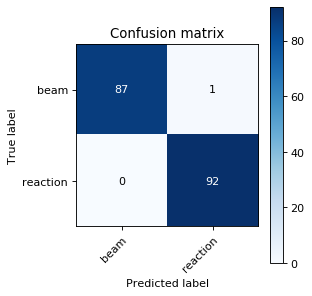

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Random forest with n_estimators trees, and usign max_features features
RFC = RandomForestClassifier(n_estimators = 5, max_features = 3)

RFC.fit(X_train_stdsc, Labels_train)

RFC_pred_train = RFC.predict(X_train_stdsc)
RFC_pred_val = RFC.predict(X_val_stdsc)
print_model_performance(Labels_train,RFC_pred_train,"Training")
print_model_performance(Labels_val,RFC_pred_val,"Validation")

### Random forest with grid search  
To find the best random forest method, a gridsearch is performed with cross-validation on the training set. 

GridSearchCV is a library function that is a member of sklearn’s model_selection package. It helps to loop through a set of predefined hyperparameters and fits a model for each setting on the training set. So, in the end, one can select the best parameters by looking at the results.

In our case we choose to tune over n_estimators, max_features, and bootstrap. The best estimator is chosen to be the one that maximizes the accuracy on the training set.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Grid Search, setting parameters
param_grid = [ {'n_estimators': [1,2,3,4,5], 'max_features': [2,3,4,5], 'bootstrap': [False,True]} ]
scoring = 'precision' # 'neg_mean_squared_error', 'accuracy', 'recall'

# Perform Grid Search on RFC
grid_search_imp = GridSearchCV(RFC, param_grid, cv=5, scoring=scoring)
# Loop on RFC for different hyper-parameters
grid_search_imp.fit(X_train_stdsc, Labels_train)
cvres = grid_search_imp.cv_results_
feature_importances = grid_search_imp.best_estimator_.feature_importances_

# Printing Result Found through Grid Search
print(">>> Best Parameters:\n", grid_search_imp.best_params_)
print("")
print(">>> Best Estimator:\n",grid_search_imp.best_estimator_)
print("")
print(">>> Importance of each feature: ")
fi_list = list(sorted(zip(np.round(feature_importances,3), feature_names), reverse=True))
print(fi_list[:])
print("")

#print(">>> Results for each set of parameters:")
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#    print("Mean score: {:.2f}%".format(mean_score*100), params)


>>> Best Parameters:
 {'bootstrap': False, 'max_features': 5, 'n_estimators': 4}

>>> Best Estimator:
 RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

>>> Importance of each feature: 
[(0.961, 'FCP'), (0.028, 'Mean Z'), (0.006, 'Total Q'), (0.002, 'stdev(X)'), (0.002, 'Pads')]



Model performance for Training set:
--------------------------------------------------------
Accuracy  : 100.00%
Precision : 100.00%
Recall    : 100.00%
F1-score  : 1.0000
MCC       : 1.0000


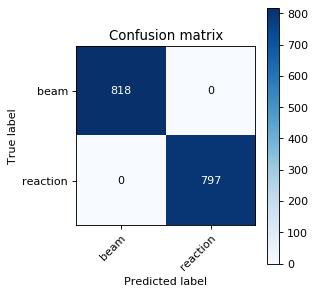


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 98.89%
Precision : 98.91%
Recall    : 98.91%
F1-score  : 0.9891
MCC       : 0.9778


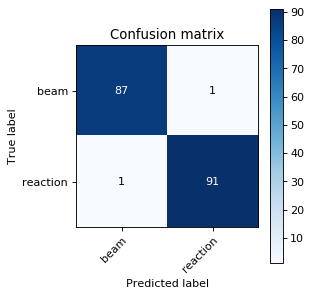

In [21]:
RFC_best = grid_search_imp.best_estimator_
RFC_pred_train = RFC_best.predict(X_train_stdsc)
RFC_pred_val = RFC_best.predict(X_val_stdsc)

# Printing Performances
print_model_performance(Labels_train,RFC_pred_train,"Training")
print_model_performance(Labels_val,RFC_pred_val,"Validation")

The best random forest estimator (found by grid search) reaches an
accuracy of over 99% on both training and validation set. Its results are very similar 
to the ones from the logistic regression. It seems the random forest estimator does overfit slightly, given its larger accuracy on the training set (compared to the validation set), 
but the limited size of the dataset makes it harder to draw firm conclusions. In case it does, one could also restrict the 'max_depth' parameter of the trees to reduce overfitting.


#  <span style="color:darkred">Dense Neural Network</span> 
The next model is a dense neural network (DNN). In this network the features act as input nodes. These are connected to neurons in a hidden layer, which have weights and biases. Based on their activation function and the inputs each neuron calculates an output as input for the next layer. When the output layer is reached the results are compared to the labels. By using backpropagation the weights and biases are updated in order to improve the correspondance of labels and output.

### Setting the DNN model

There are quite some parameters that can be tuned for a DNN, including number of hidden layers, number of neurons per layer, type of activation function, using batch normalization or dropout, which optimizer to use,...
No attempt is made to try all combinations. After varying the number of layers, adding or removing batch normalization and changing the number of nodes in the dense layers, the model below was found to perform well. Its relative simplicity ensures fast training of the neural network.

In [22]:
# Init the Sequential model
DNN_model = tf.keras.Sequential()
# Add Input layer
DNN_model.add(tf.keras.layers.InputLayer(input_shape=(X_train_stdsc.shape[1],)))
# Add hidden layer
DNN_model.add(tf.keras.layers.Dense(64, activation='relu'))
DNN_model.add(tf.keras.layers.BatchNormalization())
DNN_model.add(tf.keras.layers.Dense(64, activation='relu'))


# Add output layer.
DNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Finally, compile the model and print a summary. Loss function and optimizer is set during compilation.
DNN_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
DNN_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,737
Non-trainable params: 128
_________________________________________________________________


The number of epochs and the size of the mini batches for training is set.

In [23]:
# Set parameters for the training run. The full data set is only 2000x5 doubles so large nr of epochs and
# small batch_size will still work well even on cpu
epochs = 20
batch_size = 16

### Training the DNN
The DNN is fitted on the training set. The performance on the validation set is also shown in the output. It should not take long to complete.

In [24]:
history = DNN_model.fit(
    x=X_train_stdsc,
    y=Labels_train,
    validation_data=(X_val_stdsc, Labels_val),
    epochs=epochs,
    batch_size=batch_size,
)

Train on 1615 samples, validate on 180 samples
Epoch 1/20
1615/1615 [==============================] - 0s 229us/sample - loss: 0.0793 - acc: 0.9827 - val_loss: 0.1316 - val_acc: 0.9944
Epoch 2/20
1615/1615 [==============================] - 0s 101us/sample - loss: 0.0282 - acc: 0.9963 - val_loss: 0.0658 - val_acc: 0.9944
Epoch 3/20
1615/1615 [==============================] - 0s 85us/sample - loss: 0.0210 - acc: 0.9963 - val_loss: 0.0377 - val_acc: 0.9944
Epoch 4/20
1615/1615 [==============================] - 0s 91us/sample - loss: 0.0258 - acc: 0.9969 - val_loss: 0.0345 - val_acc: 0.9944
Epoch 5/20
1615/1615 [==============================] - 0s 105us/sample - loss: 0.0245 - acc: 0.9963 - val_loss: 0.0435 - val_acc: 0.9944
Epoch 6/20
1615/1615 [==============================] - 0s 85us/sample - loss: 0.0211 - acc: 0.9969 - val_loss: 0.0411 - val_acc: 0.9944
Epoch 7/20
1615/1615 [==============================] - 0s 91us/sample - loss: 0.0209 - acc: 0.9969 - val_loss: 0.0434 - val_acc

After training the DNN, the predictions are created and the model performance is printed.
In addition the training history of the model is shown.

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.69%
Precision : 99.38%
Recall    : 100.00%
F1-score  : 0.9969
MCC       : 0.9938


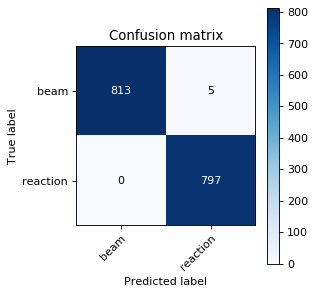


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 0.9946
MCC       : 0.9889


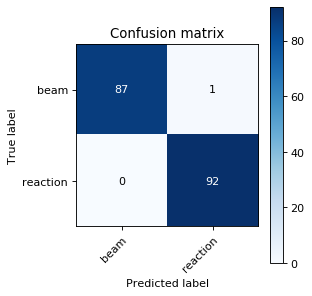

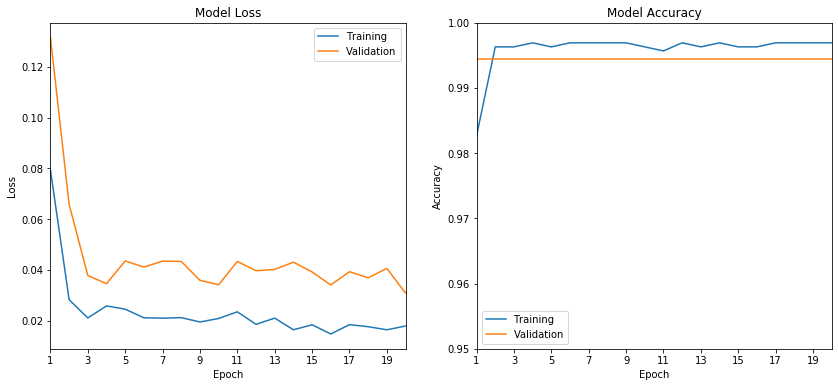

In [25]:
#the predictions contain a number in [0,1] these get mapped to 1 if >0.5 and to 0 if <0.5
#This way  a hard classifier is created
DNN_pred_train_pre = DNN_model.predict(X_train_stdsc)
DNN_pred_val_pre = DNN_model.predict(X_val_stdsc)
DNN_pred_train = DNN_pred_train_pre > 0.5
DNN_pred_val = DNN_pred_val_pre > 0.5


print_model_performance(Labels_train,DNN_pred_train,"Training")
print_model_performance(Labels_val,DNN_pred_val,"Validation")

make_nn_plots(history)

From the model history one can see it is not necessary to increase the number of epochs as its performance is stable after just a few epochs. The DNN performs well and its predictions are consistent with the logistic regression method. 

#  <span style="color:darkred">K-Means</span> 
K-Means (KM) is a method that tries to find and separate clusters in the dataset.
One main difference to the other methods used in this report is that KM is an unsupervised learning method (it does not use the labels). Nevertheless, one can still try to assign each KM-cluster to a class and see what the results are.

### Elbow method for K-Means
One parameter KM requires is the number of clusters to search for. An obvious choice would be to take the number of clusters equal to the number of classes in the dataset (two). However there exists a way to look for the optimal number of clusters called the elbow method. The KM method tries to minimize the 'inertia', which is the sum of squared error inside a cluster. However, we cannot look for the minima of this in function of the number of clusters, as more clusters always reduce the inertia. Therefore one looks for the 'elbow' of this plot, the number of clusters at which the inertia is lowered significantly, which results in a kink in the curve (which resembles an elbow).
This approach is based on [Geron's notebook](https://github.com/ageron/handson-ml/blob/master/08_dimensionality_reduction.ipynb)
        (search for 'finding the optimal number of clusters').

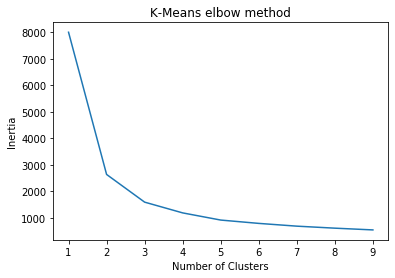

In [26]:
# Calculating Inertia for each K-Means with different number of clusters

from sklearn.cluster import KMeans
nr_clusters = range(1,10)
inertia = []

for k in nr_clusters:
    km = KMeans(n_clusters=k)
    km.fit(X_train_stdsc)
    inertia.append(km.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia') 
plt.title('K-Means elbow method')
plt.plot(nr_clusters,inertia)

fig.tight_layout()
plt.show()

From the figure above it seems there are 
two suitable candidates for the optimal number of clusters k $\in$ [2,3].

Fitting KM for these two cases is straightforward, however the cluster predictions still need to be mapped to class predictions. This means assigning a KM cluster to either beam or reaction events. KM itself does not tell us how to 
map these, so the best mapping is defined as the one that gives the highest accuracy. To do so, the accuracies are
determined for all possible mappings, excluding the trivial ones that map all clusters to the same class.

###  2 clusters K-Means
In the k=2 case finding the best mapping is quite straightforward, with only two useful mappings.

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 91.02%
Precision : 99.39%
Recall    : 82.31%
F1-score  : 0.9005
MCC       : 0.8321


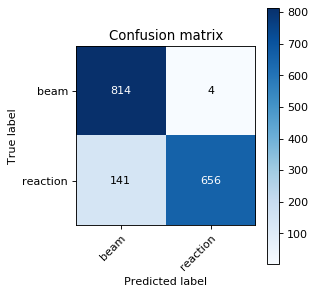


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 91.67%
Precision : 98.73%
Recall    : 84.78%
F1-score  : 0.9123
MCC       : 0.8426


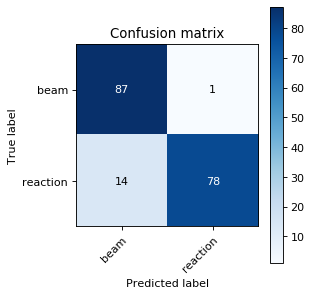

In [27]:
KM_clust2 = KMeans(n_clusters=2).fit(X_train_stdsc)

KM2_pred_train = KM_clust2.predict(X_train_stdsc)
KM2_pred_val = KM_clust2.predict(X_val_stdsc)

#Now we need to find out which cluster is which type of event
#We select the one that gives best accuracy on training set

accuracy_train_norm = accuracy_score(Labels_train, KM2_pred_train) 
accuracy_train_swap = accuracy_score(Labels_train, 1-KM2_pred_train) # swap label assigned

# Accuracy may improve when swapping the labels, in that case use swapped labels
if(accuracy_train_swap>accuracy_train_norm):
    KM2_pred_train = 1- KM2_pred_train
    KM2_pred_val = 1 - KM2_pred_val

# Printing performances
print_model_performance(Labels_train,KM2_pred_train,"Training")
print_model_performance(Labels_val,KM2_pred_val,"Validation")

### 3 clusters K-Means
In the k=3 case fincing the best mapping involves trying all the possibilities. For brevity of the report, 
the determination of the best mapping has been moved to the helper functions.

KMeans with 3 clusters performance:
Max accuracy obtained is 0.9963  using the combination number : 5
Combination 5 has the "Cluster to Lables" association = [(0, 1.0), (1, 0.0), (2, 1.0)]
----------------------------------------------------------
Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.63%
Precision : 99.38%
Recall    : 99.87%
F1-score  : 0.9962
MCC       : 0.9926


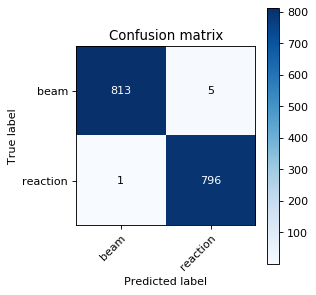


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 0.9946
MCC       : 0.9889


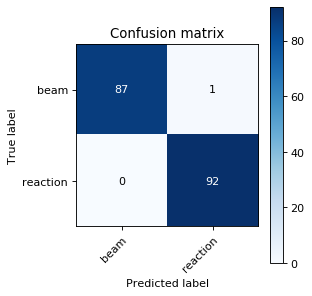

In [28]:
KM_clust3 = KMeans(n_clusters=3).fit(X_train_stdsc)

# Using function best_3cl_km in helper_function.py
KM3_pred_train, KM3_pred_val, assoc = best_cl_km(3, KM_clust3, X_train_stdsc, X_val_stdsc, Labels_train)

# Printing performances
print_model_performance(Labels_train,KM3_pred_train,"Training")
print_model_performance(Labels_val,KM3_pred_val,"Validation")

Comparing the results of 2 and 3-cluster k-means, it is clear that the 3-cluster model performs better. One should be careful not to use too many clusters because at some point it will lead to overfitting, but here this is not the case.

##  <span style="color:darkred">Support Vector Machine</span> 

Next a support vector machine is used for classification. This is a supervised learning method which uses support vectors to find a balance between maximal separation between classes and the amount of points that violate these margins. In addition different kernel functions can be used. To find an optimal model, grid search is used.
For information on the different kernels and their parameters, see the [scikit-learn page on SVM](https://scikit-learn.org/stable/modules/svm.html).

# Tuning hyper-parameters for recall

Best parameters set found on training set for recall:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on training set:

0.985 (+/-0.021) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.915 (+/-0.033) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.997 (+/-0.005) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.984 (+/-0.024) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.997 (+/-0.005) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.997 (+/-0.005) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.997 (+/-0.005) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.997 (+/-0.005) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.997 (+/-0.005) for {'C': 1, 'kernel': 'linear'}
0.997 (+/-0.005) for {'C': 10, 'kernel': 'linear'}
0.997 (+/-0.005) for {'C': 100, 'kernel': 'linear'}
0.997 (+/-0.005) for {'C': 1000, 'kernel': 'linear'}
0.948 (+/-0.017) for {'C': 1, 'coef0': 0.0, 'degree': 2, 'kernel': 'poly'}
0.996 (+/-0.005) for {'C': 1, 'c

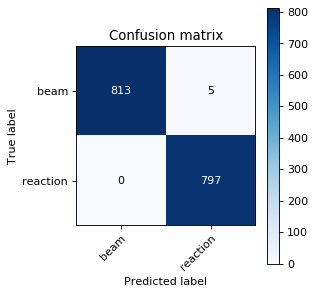


Model performance for validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 0.9946
MCC       : 0.9889


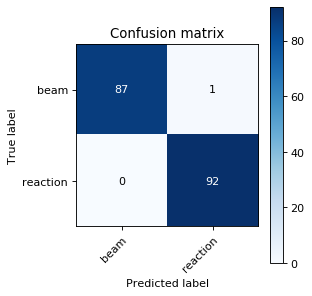

In [29]:
from sklearn.metrics import classification_report
from sklearn import svm


#Using grid search
#Select optimal parameters by cross-validation

# Set of tuning parameters
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                   {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'], 'C': [1, 10, 100, 1000], 'degree': [2,3,4], 'coef0': [0.,0.01,0.1,0.5,1.5]},
                   {'kernel': ['sigmoid'], 'C': [1, 10, 100, 1000], 'coef0': [0.,0.01,0.1,0.5,1.5]}]

#select a metric to select best SVM (comment one or the other)

#score = 'precision'
score = 'recall'


print("# Tuning hyper-parameters for %s" % score)
print()

SVM = GridSearchCV(
    svm.SVC(), tuned_parameters, cv=5, scoring='%s_macro' % score
)
SVM.fit(X_train_stdsc,Labels_train)

print("Best parameters set found on training set for %s:" % score)
print()
print(SVM.best_params_)
print()
print("Grid scores on training set:")
print()
means = SVM.cv_results_['mean_test_score']
stds = SVM.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, SVM.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()

SVM_pred_train = SVM.predict(X_train_stdsc)
SVM_pred_val = SVM.predict(X_val_stdsc)

print_model_performance(Labels_train,SVM_pred_train,"training")
print_model_performance(Labels_val,SVM_pred_val,"validation")

This model also performs well on both training and validation set. In fact it gives the same predictions as the DNN model and the logistic regression (using scaled data). Perhaps this fact depends on the random number seed, but the similarity between these different methods is striking.

##  <span style="color:darkred">Voting Classifier</span> 

A voting classifier is a way to combine the predictions of multiple models into one prediction. Here a simple approach to voting is used. Each model prediction is counted as a vote for one of the two classes (beam or reaction). The class gaining the majority of the votes is selected. It is hoped that this voting classifier improves on the performance of the individual models. 

In our implementation a model votes one if it classifies the event as a reaction event and zero otherwise. These votes are added. Five models are used: DNN, 3-cluster k-means, logistic regression (using standardscaled data), random forest and support vector machine. If the sum of votes exceeds two, this means at least three models voted for reaction, the voting classifier selects reaction. If not it selects beam event.

<a id='VotingClassifier'></a>

Model performance for training set:
--------------------------------------------------------
Accuracy  : 99.69%
Precision : 99.38%
Recall    : 100.00%
F1-score  : 0.9969
MCC       : 0.9938


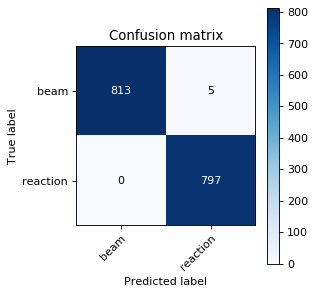


Model performance for validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 0.9946
MCC       : 0.9889


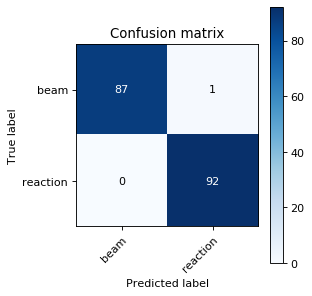

In [30]:
Vote_pred_train = np.zeros(len(DNN_pred_train))
Vote_pred_val = np.zeros(len(DNN_pred_val))

total_vote_train = np.zeros(len(DNN_pred_train))
total_vote_val = np.zeros(len(DNN_pred_val))

for i in range(len(DNN_pred_train)):
    TotalVotesTrain = DNN_pred_train[i] + KM3_pred_train[i] + LR_pred_train[i] + RFC_pred_train[i] + SVM_pred_train[i]
    total_vote_train[i] = TotalVotesTrain
    if TotalVotesTrain > 2:
        Vote_pred_train[i] = 1
    else:
        Vote_pred_train[i] = 0
for i in range(len(DNN_pred_val)):
    TotalVotesVal = DNN_pred_val[i] + KM3_pred_val[i] + LR_pred_val[i] + RFC_pred_val[i] + SVM_pred_val[i]
    total_vote_val[i] = TotalVotesVal
    if TotalVotesVal > 2:
        Vote_pred_val[i] = 1
    else:
        Vote_pred_val[i] = 0
    
print_model_performance(Labels_train,Vote_pred_train,"training")
print_model_performance(Labels_val,Vote_pred_val,"validation")


One can see the voting classifier obtains good results, but does not represent an improvement 
over the individual models. However, this does not come as a surprise. As noted above, three of the models
(logistic regression, DNN and SVM) yield the same predictions. The voting classifier follows their decisions
because together these form a majority among the models.

# Convolutional Neural Network

### How do we create an image out of an event??
This is how an event looks like: 
```
DataList[0]:
array([(-2.45412970e+00,  1.45075214, 834., 417, 6.73360577e+03, 0),
       (-1.33514404e-05,  2.79990482, 834., 417, 1.25854633e+04, 0),
       (-2.45412970e+00, -1.45075214, 834., 417, 1.70520808e+03, 0),
       (...
       (-7.36236525e+00, -1.45075214, 998., 499, 1.74805170e+01, 0)]
```

We want to convert this in a 2D image, to use for the CNN algorithm. 

The first thought is to use the the (x,y) projection: we will pixel the surface in order to save it as a 2D matrix.
We would like that every pad correspond to a matrix element, or at least that every matrix element is associated to the same number of pads.

Once the 2D matrix is prepared, we need to fill the image with the pixel values: the best choice is to use the charge deposited on that pad as pixel value. We will use 1/0 ("fired/not fired"), since it represents a good check for bugs, and a good way of visualizing the data.

With the images produced we will feed the CNN algorithm, and evaluate the perormances.

### Preparing the data:
We first store teh data in a convenient format.

In [31]:
# Generate arrays to perform math operations
points, xy_values = prepare_images_data(DataList)

###  Get Pad Plane Dimenstion.
We can extract the dimension of the image we want to create, based on the max/min values of the (x,y)-tuple.
We will assume the pad plane is squared.
The information concerning the pad plane will be printed below.

In [32]:
x_max = np.amax(xy_values[:,0])
x_min = np.amin(xy_values[:,0])  
y_max = np.amax(xy_values[:,1])
y_min = np.amin(xy_values[:,1])
x_uniques = np.unique(np.around(xy_values[:,0],3))
y_uniques = np.unique(np.around(xy_values[:,1],3))

print("PAD PLANE Dimensions: ")
print("")
print("X range: ", (round(x_max,2), round(x_min,2)))
print("Y range: ", (round(y_max,2), round(y_min,2)))
print("")

# Show (some) discrete values that x and y can assume...
print("Possible positive values of x: ")
print(x_uniques[x_uniques>0][0:10], " and so on...")
print("Possible positive values of y: ")
print(y_uniques[y_uniques>0][0:10], " and so on...")

PAD PLANE Dimensions: 

X range:  (255.23, -255.23)
Y range:  (252.37, -252.37)

Possible positive values of x: 
[ 2.454  4.908  7.362  9.816 12.271 14.725 17.179 19.633 22.087 24.541]  and so on...
Possible positive values of y: 
[ 1.451  2.8    2.868  5.701  5.837  7.051  9.952 11.301 11.369 14.203]  and so on...


We can see that the (x,y)-tuple assume only discete values (as expected, since we have a discrete number of pads). The positions of the tuple correspond at the center of the corresponding pad.

### Visualizing the Pad Plane: 
In order to genereate a proper matrix, we first need how to set the grid on the (x,y) place. The exercise does not give us the dimension of the single pads, but we can figure it out.
Plotting the superposition of all the events, we can visualize the pad plane structure.

Pad Plane: Superposition of all Events


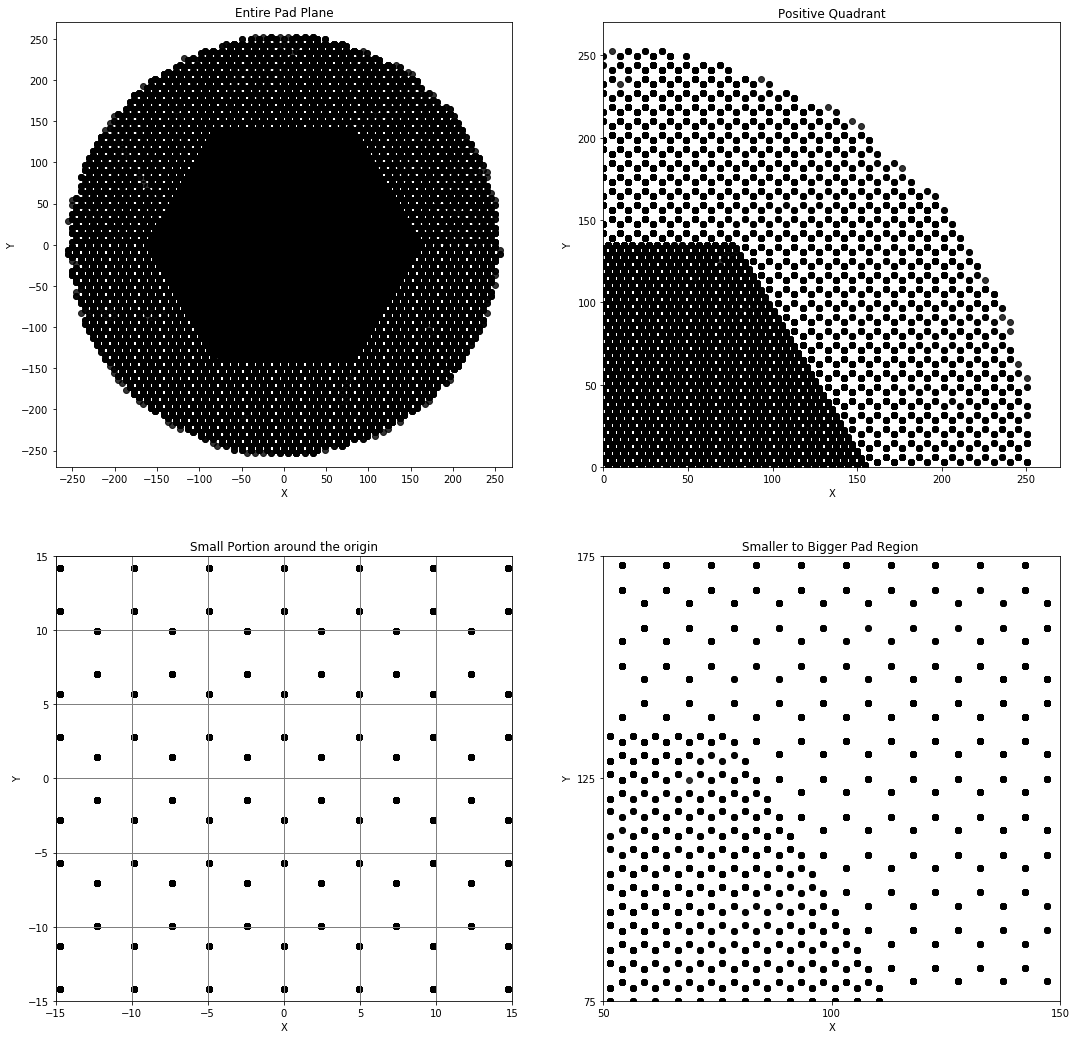

In [33]:
print("Pad Plane: Superposition of all Events")
plot_pad_plane(xy_values)

We deduce different things from thess images:
- The simulated events seems to span all over the pad plane, as should be.
- The singlepad plane shape is triagular, and we can calculate the exact dimension.
- The pad plane does not have the same dimension, but in the most peripheral region, the pads become bigger (but remain triangular).

We can visualize even a single event to see which pads fired:

Plotting Event_1 Fired Pads:


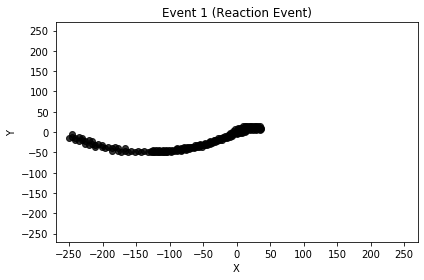

In [34]:
print("Plotting Event_1 Fired Pads:")
fig, ax = plt.subplots( figsize=(6, 4))
xy_event_1 = get_xy_event(points, 1)

ax.set_title("Event 1 (Reaction Event)")
ax.scatter(xy_event_1[:,0],xy_event_1[:,1], c = "black", alpha=0.8)
ax.set_xlabel("X")
ax.set_ylabel("Y")    
ax.set_xticks(np.arange(-250, +251, 50))
ax.set_yticks(np.arange(-250, +251, 50))
ax.set_xlim(-270,+270)
ax.set_ylim(-270,+270)

fig.tight_layout()
plt.show()

### Seting the 2D Matrix:
From the previous plot, in particular the one of the Pad Plane structure close to the origin, we can start thinkin ga good way in order to "pixel/grid" our surface.

We divide the surface in little squared pixels, computing manually the spacing among each pad, both in x, and in y direction. It requires a bit of work, in order to etract the proper values.

Some of these numbers have been obtain looking studying the grid, extracting values based on geometric consideration, and using these value in order to compute the grid spacing with a good precision, that's why some numerical values appear "hard coded". I am aware the cell above looks quite ugly, anyway form the plots that follow it is possible to check that the calculation is correct. 

In [35]:
#Calculate with better precision
x_temp = np.unique(np.around(xy_values[:,0],5))
y_temp = np.unique(np.around(xy_values[:,1],5))


# X - spacing calculation
print("Calculatig X-spacing")
print("--------------------------------------------------")
print("Showing last x values: ", x_temp[-4:])
print("Approximate number of cells: ", x_temp[-1]/2.454) #2.454 is the approximate spacing
nxc = int(round(x_temp[-1]/2.454))
print("Correct number of cells: ", nxc)
x_spc = x_temp[-1]/nxc # this is the spacing calculated more accurately
print("So that the corret spacing is ", x_spc)
x_shift = x_spc/2
print("")
# Y - spacing calculation
print("Calculatig X-spacing")
print("--------------------------------------------------")
print("Last y values: ", y_temp[-4:])
#print(y_temp[-30:-20]) # here you can find the value of 134.57027
print("Approximate number of exagons:", (134.57027+1.4508)/(7.0506+1.4508))
nyex = int(round((134.57027+1.4508)/(7.0506+1.4508)))
print("Correct number of exagons: ", nyex)
y_spc = (134.57+1.4508)/(nyex*4)
print("The corret spacing is ", y_spc)
y_shift = 0

#y_spc = 2.1422616225
#y_shift = 0

Calculatig X-spacing
--------------------------------------------------
Showing last x values:  [245.4118  250.32001 250.32004 255.22827]
Approximate number of cells:  104.005
Correct number of cells:  104
So that the corret spacing is  2.454117980769231

Calculatig X-spacing
--------------------------------------------------
Last y values:  [240.9044  243.87364 249.40572 252.37495]
Approximate number of exagons: 15.999843555179144
Correct number of exagons:  16
The corret spacing is  2.1253249999999997


#### Plotting the Grid
This function will show the grid parameters, and plot the grid. It is possible to check whether it corresponds to the desired result.

Grid Parameters:

X-direction:
----------------------------------
X grid spacing:  2.454117980769231
First x cell limits:  (1.2270589903846154, 3.681176971153846)
Number of pixel on x direction: 105*2 =  210

Y-direction:
----------------------------------
X grid spacing:  2.1253249999999997
First y cell limits:  (0, 2.1253249999999997)
Number of pixel in y direction: 119*2 =  238


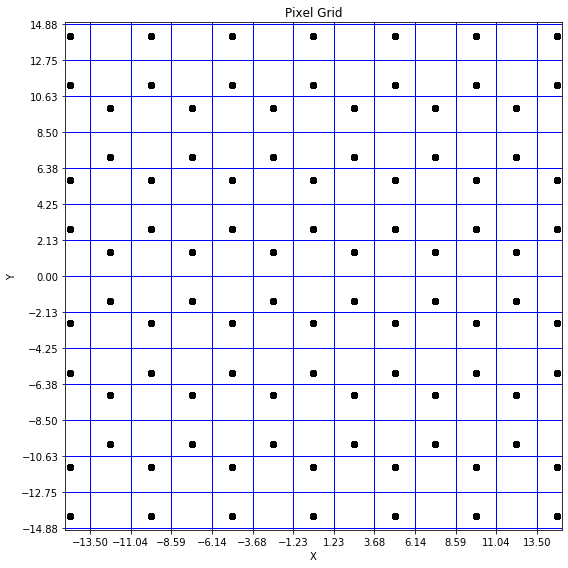

In [36]:
show_grid(xy_values, x_max, y_max, x_spc, y_spc, x_shift, y_shift)

### Improved Grid
We do not like that many pads will have for sure no charge, since they do not contain any points. We try to merge four pads together, and use the new grid as show below. This grid guarantees that each pixel contain the same amount of pad (i.e. 2 pads per pixel).

Grid Parameters:

X-direction:
----------------------------------
X grid spacing:  4.908235961538462
First x cell limits:  (1.2270589903846154, 6.135294951923077)
Number of pixel on x direction: 53*2 =  106

Y-direction:
----------------------------------
X grid spacing:  4.250649999999999
First y cell limits:  (0, 4.250649999999999)
Number of pixel in y direction: -59*2 =  -118


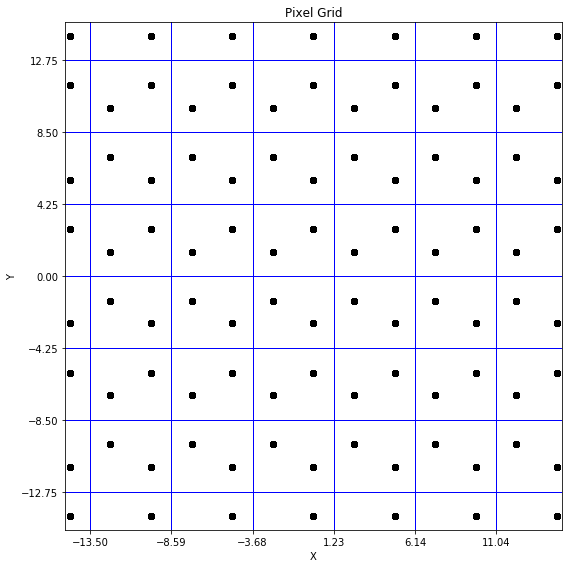

In [37]:
x_grid = x_spc*2
y_grid = y_spc*2
x_shift_grid = x_grid/4
y_shift_grid = 0

show_grid(xy_values, x_max, y_min, x_grid, y_grid, x_shift_grid, y_shift_grid)

### Transalte an event into an image
We will generate two different type of images:
- images: pixel value is equal to charge deposited.
- images_pads: pixel value is the number of time that pixel fired during the event.

The choice that carries more physical meaning is to have the image pixels filled with the respective charge deposited, but also plotting the images of pad "fired/not fired" is pretty interesting.

First, we define the pixel values accordingly, then we assign it to the proper matrix element.


In [38]:
Q = []
pads = []

for i in range(len(points)): # loop on event number
    Q.append([])
    pads.append([])
    for j in range(len(points[i])): # loop on event rows
        Q[i].append(math.log(DataList[i][j][4])) 
        pads[i].append(1)

images = generate_images(points, Q, x_max, y_max, x_grid, y_grid, x_shift_grid, y_shift_grid)
images_pads = generate_images(points, pads, x_max, y_max, x_grid, y_grid, x_shift_grid, y_shift_grid)

The images generated have a dimension : (120, 106)
The images generated have a dimension : (120, 106)


### Reducing Images Dimenstion

We want to reduce the dimension to limit the time to run the model. Also, most of the information is contained in the center of the pad plane, so we ""throw away" the most peripher pixels.

In [39]:
# Working with reduced images
images_red = reduce_images_dim(images, 40)
images_pads_red = reduce_images_dim(images_pads, 40)


Images of dimension: (120, 106)  reduced to dimension of  (40, 40)
The external pixels have been removed
Images of dimension: (120, 106)  reduced to dimension of  (40, 40)
The external pixels have been removed


### Merging Pixels
In order to compute faster, we will make the picture more "blurred", converting block of 4 pixels into 1. The image will reduce significatively.

Edit: We decided to not use this step in order to increase accuracy

In [40]:
images_red_merged = merge_pixels(images_red, 2, 2)
images_pads_red_merged = merge_pixels(images_pads_red, 2, 2)

Images of dimension: (40, 40)  reduced to dimension of  (20, 20)
The pixels have been merged in block of  (2, 2)  along the x, and y axes respectively
Images of dimension: (40, 40)  reduced to dimension of  (20, 20)
The pixels have been merged in block of  (2, 2)  along the x, and y axes respectively


### Normalized the images
Last step is to normalize the images, we use the range (0,255) only integer.  

In [41]:
images_processed= normalize_image_data(images_red)
images_pads_processed= normalize_image_data(images_pads_red)

### Visualizing the images obtained
We use this function in order to plot the images obtained after the "pre-processing" phase.
We will plot the two type of images: 
- pixel values = fired/not fired,
- pixel values = Q (deposited charge).

#### Difference in the two types of images

Printing Images Pads


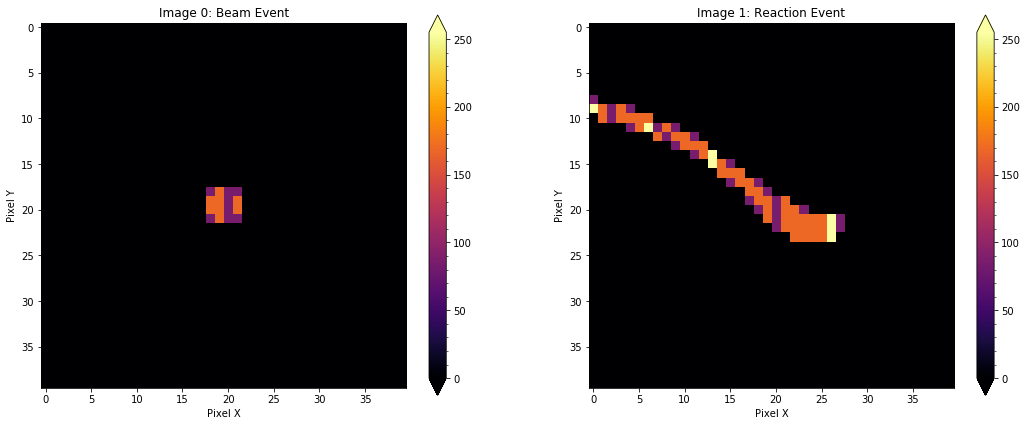

Printing Images Q


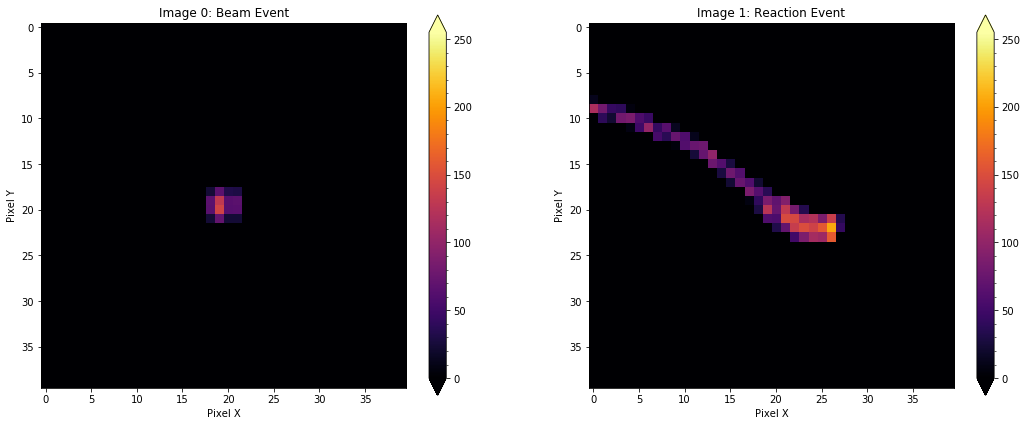

In [42]:
print("Printing Images Pads")
plot_images(images_pads_processed, Labels,0, 1)
print("Printing Images Q")
plot_images(images_processed, Labels,0, 1)
#plot_images(images_ML_pads, Labels)

#### Plotting images based on charge deposited

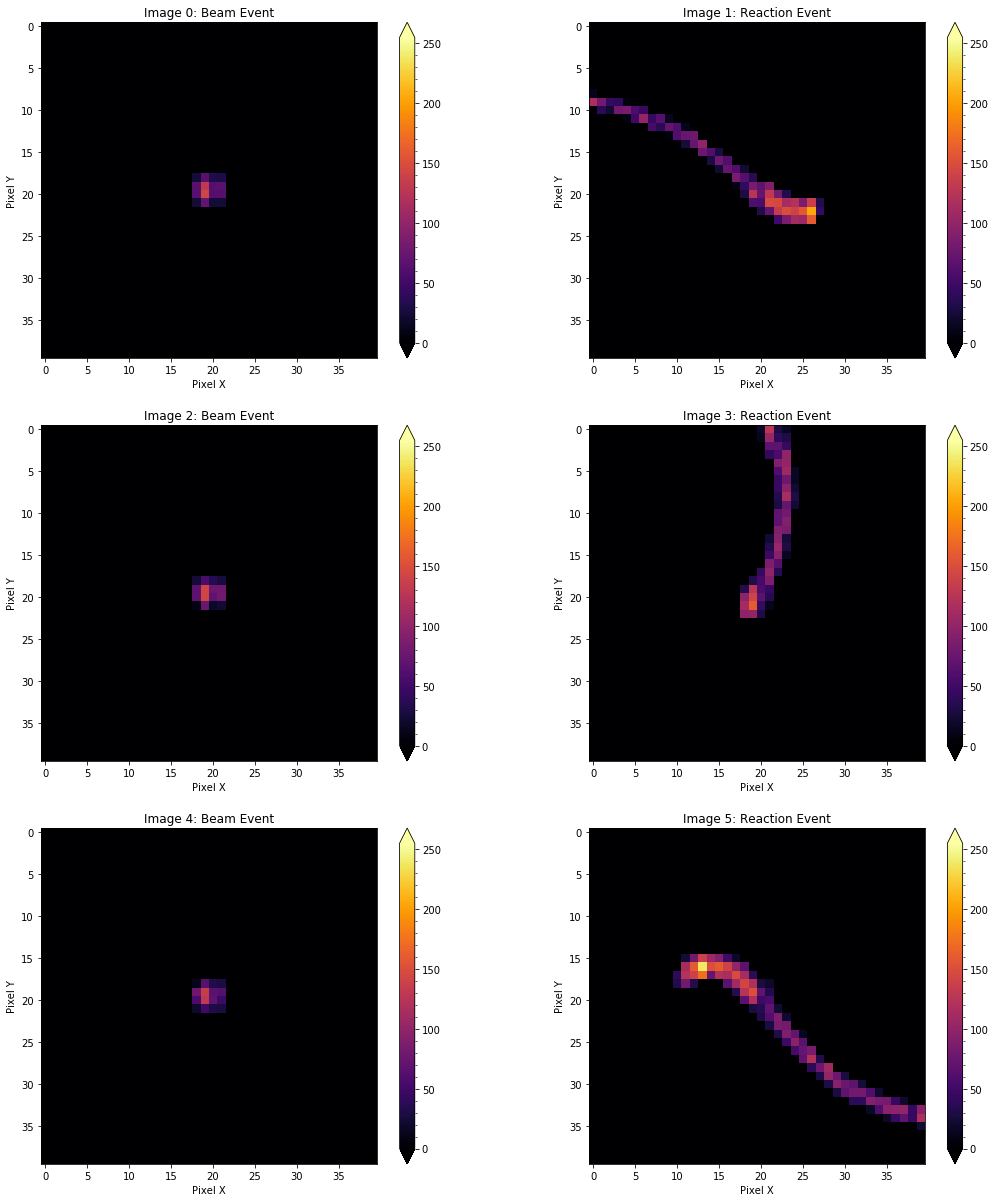

In [43]:
plot_images(images_processed, Labels,0, 3)

## Convolutional Network

The images are now ready to be processed  by the CNN algorithms. We just neeed to define train/val images split, using train_idx and val ixd.

In [44]:
from tensorflow.keras.utils import to_categorical

images_ML = np.reshape(images_processed, (images_processed.shape[0], images_processed.shape[1], images_processed.shape[2], 1)) # image, x, y, ch

images_train = images_ML[train_idx]
images_val = images_ML[val_idx]

Labels2_train = to_categorical(Labels_train)
Labels2_val = to_categorical(Labels_val)

### Setting the model
Defining my CNN model.  

In [45]:
my_model = tf.keras.Sequential()

my_model.add(tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(10, 10),
        activation='relu',
        padding='same',
        input_shape=images_ML.shape[1:] # Shape of a single imag
                                )
        )

my_model.add(BatchNormalization())

my_model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
my_model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
my_model.add(tf.keras.layers.Flatten())
my_model.add(tf.keras.layers.Dense(40, activation='relu'))
my_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Once the model is defined, we need to compile it. 
# This is where we specify the loss function, optimizer, and metrics if we want.
my_model.compile(
    tf.keras.optimizers.Adam(lr=0.001, beta_1=0.8, beta_2=0.9),
    loss='binary_crossentropy', #'sparse_categorical_crossentropy',
    metrics=['accuracy']
)
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 40, 128)       12928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          73792     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                163880    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [46]:
history = my_model.fit(images_train,
          Labels_train,
          batch_size=128,
          epochs=10,
          validation_data=(images_val, Labels_val));

Train on 1615 samples, validate on 180 samples
Epoch 1/10
1615/1615 [==============================] - 38s 24ms/sample - loss: 1.2168 - acc: 0.7988 - val_loss: 0.4290 - val_acc: 0.6833
Epoch 2/10
1615/1615 [==============================] - 41s 26ms/sample - loss: 0.1277 - acc: 0.9659 - val_loss: 0.3851 - val_acc: 0.8444
Epoch 3/10
1615/1615 [==============================] - 38s 23ms/sample - loss: 0.0762 - acc: 0.9765 - val_loss: 0.1499 - val_acc: 0.9889
Epoch 4/10
1615/1615 [==============================] - 45s 28ms/sample - loss: 0.0469 - acc: 0.9845 - val_loss: 0.1538 - val_acc: 0.9833
Epoch 5/10
1615/1615 [==============================] - 37s 23ms/sample - loss: 0.0384 - acc: 0.9864 - val_loss: 0.2597 - val_acc: 0.9722
Epoch 6/10
1615/1615 [==============================] - 36s 22ms/sample - loss: 0.0307 - acc: 0.9907 - val_loss: 0.1527 - val_acc: 0.9833
Epoch 7/10
1615/1615 [==============================] - 35s 21ms/sample - loss: 0.0225 - acc: 0.9932 - val_loss: 0.0993 - val

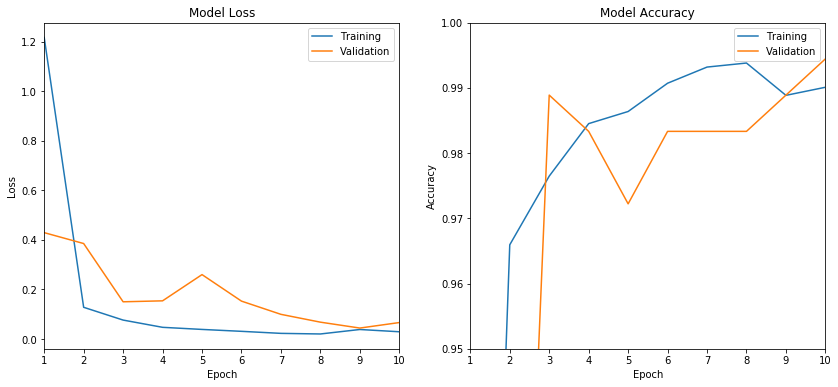

In [47]:
make_nn_plots(history,0.95)

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.50%
Precision : 99.37%
Recall    : 99.62%
F1-score  : 0.9950
MCC       : 0.9901


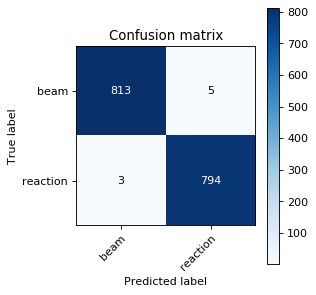


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 0.9946
MCC       : 0.9889


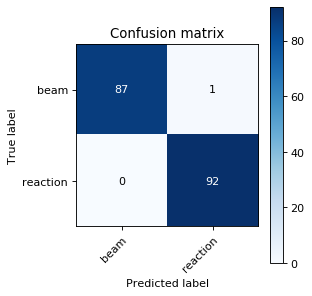

In [48]:
CNN_pred_train_pre = my_model.predict(images_train)
CNN_pred_val_pre = my_model.predict(images_val)
CNN_pred_train = CNN_pred_train_pre > 0.5
CNN_pred_val = CNN_pred_val_pre > 0.5
print_model_performance(Labels_train, CNN_pred_train, "Training")
print_model_performance(Labels_val, CNN_pred_val, "Validation")

### Using VGG model
Importing a pre-trained VGG model.  

In [49]:
images_train_3d = np.expand_dims(images_train,3)
images_train_VGG = np.repeat(images_train,3,3)

images_val_3d = np.expand_dims(images_val,3)
images_val_VGG = np.repeat(images_val,3,3)

In [50]:
model = build_pretrained_vgg_model((images_train_VGG.shape[1],images_train_VGG.shape[2],3), 2)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [51]:
history_VGG = model.fit(images_train_VGG,
          Labels_train,
          batch_size=32,
          epochs=10,
          validation_data=(images_val_VGG, Labels_val));

Train on 1615 samples, validate on 180 samples
Epoch 1/10
1615/1615 [==============================] - 16s 10ms/sample - loss: 0.2264 - acc: 0.9362 - val_loss: 0.1028 - val_acc: 0.9778
Epoch 2/10
1615/1615 [==============================] - 16s 10ms/sample - loss: 0.0828 - acc: 0.9814 - val_loss: 0.0860 - val_acc: 0.9778
Epoch 3/10
1615/1615 [==============================] - 18s 11ms/sample - loss: 0.0628 - acc: 0.9820 - val_loss: 0.0723 - val_acc: 0.9778
Epoch 4/10
1615/1615 [==============================] - 16s 10ms/sample - loss: 0.0530 - acc: 0.9851 - val_loss: 0.1077 - val_acc: 0.9667
Epoch 5/10
1615/1615 [==============================] - 16s 10ms/sample - loss: 0.0621 - acc: 0.9827 - val_loss: 0.0729 - val_acc: 0.9722
Epoch 6/10
1615/1615 [==============================] - 16s 10ms/sample - loss: 0.0420 - acc: 0.9851 - val_loss: 0.0751 - val_acc: 0.9667
Epoch 7/10
1615/1615 [==============================] - 16s 10ms/sample - loss: 0.0387 - acc: 0.9882 - val_loss: 0.0962 - val

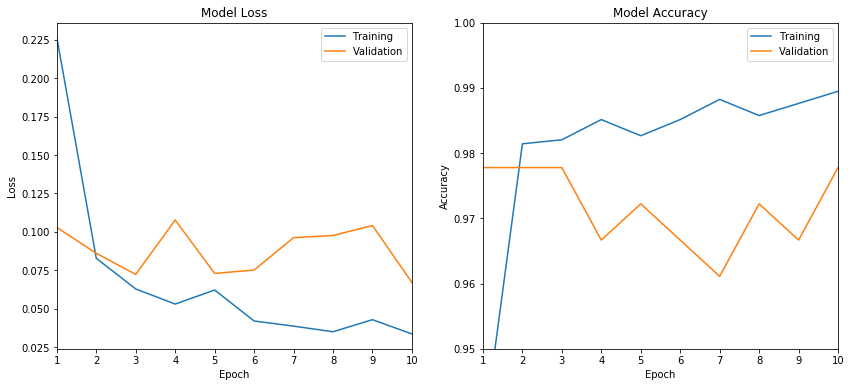

In [52]:
make_nn_plots(history_VGG,0.95)

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.32%
Precision : 99.25%
Recall    : 99.37%
F1-score  : 0.9931
MCC       : 0.9864


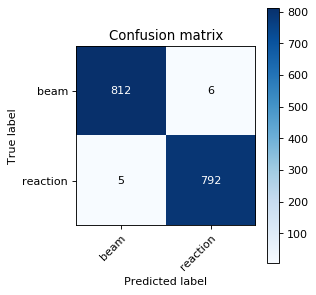


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 97.78%
Precision : 97.83%
Recall    : 97.83%
F1-score  : 0.9783
MCC       : 0.9555


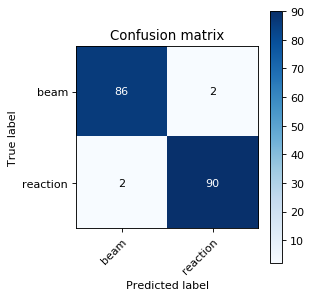

In [53]:
VGG_pred_train_pre = model.predict(images_train_VGG)
VGG_pred_val_pre = model.predict(images_val_VGG)
VGG_pred_train = VGG_pred_train_pre > 0.5
VGG_pred_val = VGG_pred_val_pre > 0.5
print_model_performance(Labels_train, VGG_pred_train, "Training")
print_model_performance(Labels_val, VGG_pred_val, "Validation")

#  <span style="color:darkred">Dimensionality Reduction</span> 

Dimensionality reduction means transforming the feature set to a lower-dimensional space. This is done to 
speed up training of models by reducing the number of features. In addition it also allows for a 
2d visualization of the dataset (if the feature set is reduced to two dimensions). In this section two methods for dimensionality reduction are discussed, namely PCA and t-SNE. These are applied to reduce the five-dimensional feature set above to a new two-dimensional representation.

## Principal Components Analysis (PCA)

Principal Components Analysis (PCA) is an often used method. It works by finding the hyperplane closest 
to the datapoints and subsequently projects the datapoints on this hyperplane. The two dimensions of the hyperplane 
give rise to a new 2d coordinate ($x_1$,$x_2$) for each datapoint. The PCA method is implemented in scikit-learn.

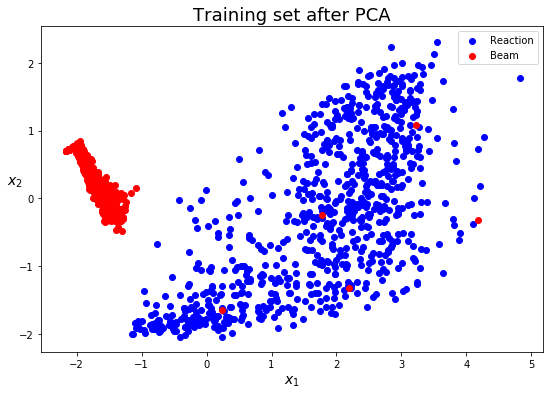

In [54]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_train_PCA = pca.fit_transform(X_train_stdsc)
    
plot_latent_space(X_train_PCA, Labels_train, 'PCA')

One can see the separation between beam and reaction events is quite good. Only a few beam events are hidden 
between the reaction events.

## t-distributed Stochastic Neighbor Embedding (t-SNE)

[t-SNE](https://lvdmaaten.github.io/tsne/) is another method used for the visualization of high dimensional data.
One slight drawback for our purposes is that it does not give an explicit mapping. This means that new points cannot
be transformed and added after fitting the training set, altough one could just refit the entire dataset. 
t-SNE is also implemented in scikit-learn.

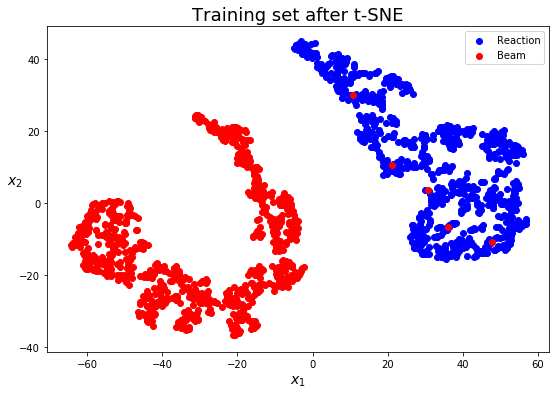

In [55]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_train_TSNE = tsne.fit_transform(X_train_stdsc)

plot_latent_space(X_train_TSNE, Labels_train, 't-SNE')

Altough the shape differs from the one obtained with PCA, one again finds two well separated bodies 
and some beam events hiding among the 
reaction events. Remark that we use labels $x_1$ and $x_2$ for the two dimensions for both PCA and t-SNE, but that the coordinates are different for the the two methods.


#### Visualization of models using dimensionality reduction (PCA, t-SNE) 

The advantage of these two-dimensional feature sets is that visualization of the models becomes possible.
We restrict ourselves to showing the visualization results. The actual computations are stored inside the 
helper functions. The models used are the same ones as described before (logistic regression, random forest
and support vector machine), altough they are simplified versions (for example no grid search was used).

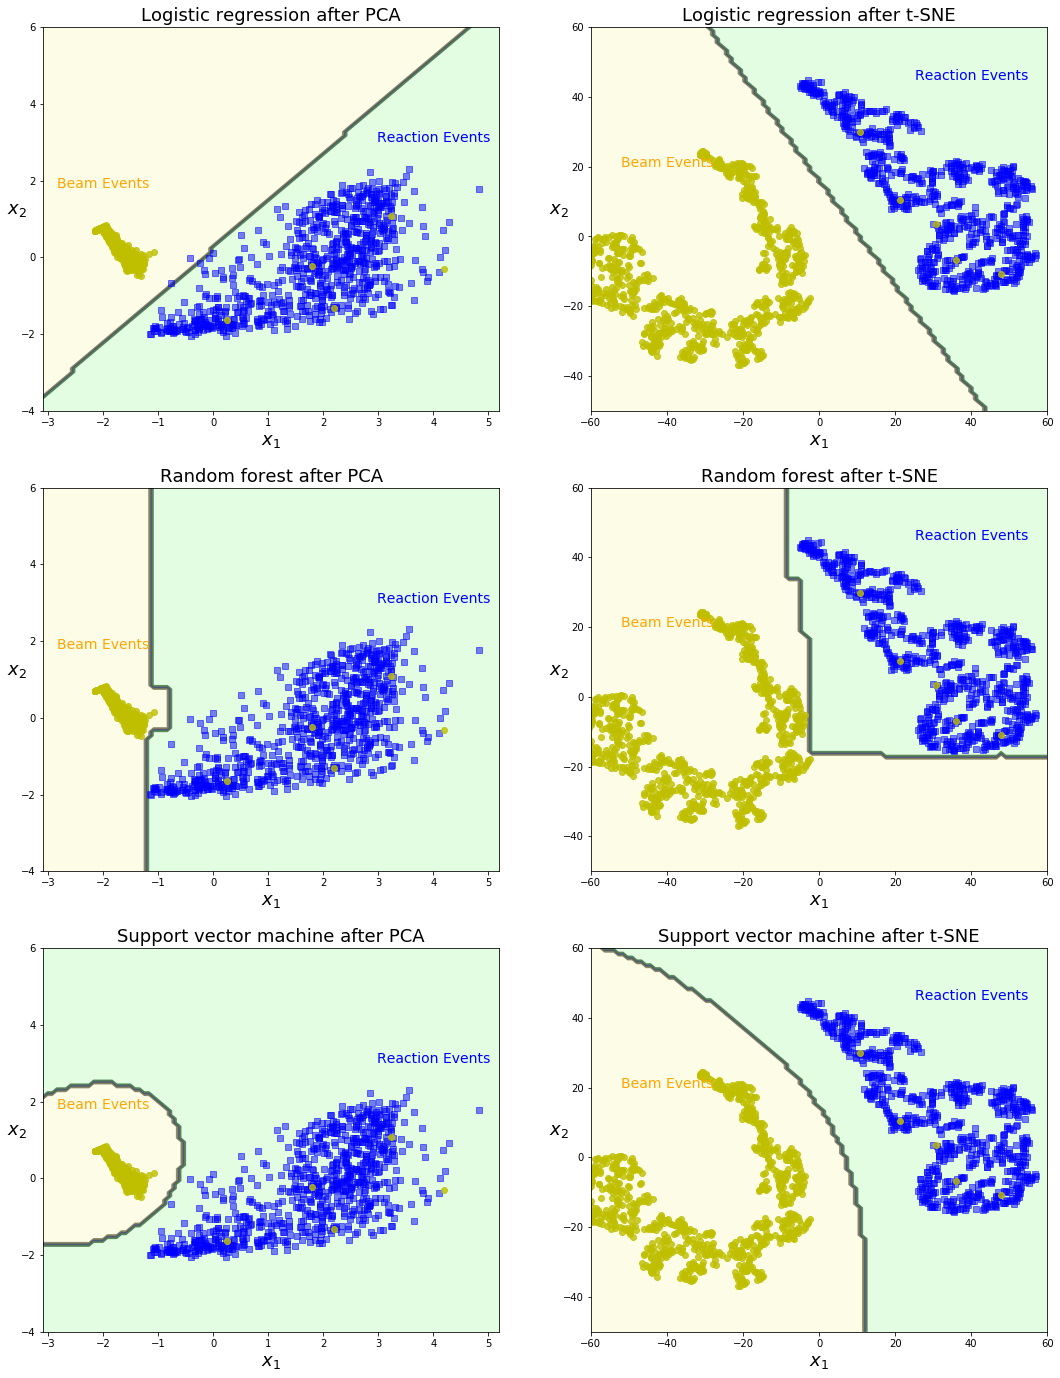

In [56]:
make_2d_vis(X_train_PCA,X_train_TSNE,Labels_train)

It is remarkable how the three models have predictions that agree well on the training set, even though all three use
a different decision boundary. One could again make predictions on the validation set using these models, however since
they use essentially the same information (albeit in a lower dimensionality) as the original models we choose not
to repeat this. In addition the same five misclassified points (in the training set) from earlier (see voting classifier confusion matrix) correspond to the beam events hidden here among the reaction events. Therefore we do expect similar results for the PCA and t-SNE reduced models.

##  AutoEncoder

An Autoencoder is a kind of neural networks which is trained to reproduce the input vector. We can picture this kind of networks as built of two main part:
1. Encoder, $h=f(x)$
2. Decoder, $r=g(h)$

If the dimensionality of the input vector $\vec{x}$ is higher than the hidden encoding layer $\vec{h}$ the autoencoder is called $\textbf{undercomplete}$.
We can use this type of network in order to learn a lower dimensionality representation of our data, in fact, while training the network in order to learn the mapping $g(f(x))=x$ the 
encoder network should learn a meaningful representation of our data which ensure the reconstruction through the decoder network.


If our data shows clusters in Latent space we are confident that our network has learned a meaningfull lower dimensionality representation of our dataset.

First we normalize the data, for this example we normalize our dataset using the Min-Max Scaling

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler_mmsc = MinMaxScaler()
scaler_mmsc.fit(X)

X_train_mmsc = scaler_mmsc.transform(X_train)
X_val_mmsc = scaler_mmsc.transform(X_val)

In [58]:
# Building the autoencoder

autoencoder = tf.keras.Sequential()

# Input Layer
autoencoder.add(tf.keras.Input(shape=(5,)))

# Encoder Part
autoencoder.add(tf.keras.layers.Dense(4,activation='tanh', name='Encoder1'))
autoencoder.add(tf.keras.layers.Dense(2,activation='tanh', name='Encoder2'))

# Decoder Part
autoencoder.add(tf.keras.layers.Dense(4,activation='tanh', name='Decoder1'))
autoencoder.add(tf.keras.layers.Dense(5,activation='tanh', name='Decoder2'))

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder1 (Dense)             (None, 4)                 24        
_________________________________________________________________
Encoder2 (Dense)             (None, 2)                 10        
_________________________________________________________________
Decoder1 (Dense)             (None, 4)                 12        
_________________________________________________________________
Decoder2 (Dense)             (None, 5)                 25        
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


Let's use as optimizer adam with the following parameters:
1. Learning rate: $10^{-3}$
2. $\beta_1 = 0.99$
3. $\beta_2 = 0.999$

As loss function we use the Mean Squared Error.

In [59]:
# Compiling Model

beta_1 = 0.99
beta_2 = 0.999

autoencoder.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=beta_1, beta_2=beta_2),
        loss      = tf.keras.losses.MeanSquaredError(),
        metrics   = ['mse']#[keras.metrics.MeanSquaredError()]
    )


In [60]:
# Training The Model

history = autoencoder.fit(
                            X_train_mmsc,
                            X_train_mmsc,
                            validation_data = (X_val_mmsc,X_val_mmsc),
                            batch_size=128,
                            epochs=800
                         )

Train on 1615 samples, validate on 180 samples
Epoch 1/800
1615/1615 [==============================] - 0s 124us/sample - loss: 0.2529 - mean_squared_error: 0.2529 - val_loss: 0.2343 - val_mean_squared_error: 0.2343
Epoch 2/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.2225 - mean_squared_error: 0.2225 - val_loss: 0.2070 - val_mean_squared_error: 0.2070
Epoch 3/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.1989 - mean_squared_error: 0.1989 - val_loss: 0.1850 - val_mean_squared_error: 0.1850
Epoch 4/800
1615/1615 [==============================] - 0s 14us/sample - loss: 0.1793 - mean_squared_error: 0.1793 - val_loss: 0.1667 - val_mean_squared_error: 0.1667
Epoch 5/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1510 - val_mean_squared_error: 0.1510
Epoch 6/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.1480 - mean_squared_error: 0.1

1615/1615 [==============================] - 0s 10us/sample - loss: 0.0538 - mean_squared_error: 0.0538 - val_loss: 0.0537 - val_mean_squared_error: 0.0537
Epoch 50/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0531 - mean_squared_error: 0.0531 - val_loss: 0.0529 - val_mean_squared_error: 0.0529
Epoch 51/800
1615/1615 [==============================] - 0s 14us/sample - loss: 0.0523 - mean_squared_error: 0.0523 - val_loss: 0.0520 - val_mean_squared_error: 0.0520
Epoch 52/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0514 - mean_squared_error: 0.0514 - val_loss: 0.0512 - val_mean_squared_error: 0.0512
Epoch 53/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0506 - mean_squared_error: 0.0506 - val_loss: 0.0504 - val_mean_squared_error: 0.0504
Epoch 54/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.0495 - val_mean_squared_error: 0.0495

1615/1615 [==============================] - 0s 10us/sample - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0211 - val_mean_squared_error: 0.0211
Epoch 98/800
1615/1615 [==============================] - 0s 14us/sample - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 99/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 100/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 101/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 102/800
1615/1615 [==============================] - 0s 14us/sample - loss: 0.0194 - mean_squared_error: 0.0194 - val_loss: 0.0202 - val_mean_squared_error: 0.0

1615/1615 [==============================] - 0s 19us/sample - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 146/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 147/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 148/800
1615/1615 [==============================] - 0s 14us/sample - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 149/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 150/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0109 - val_mean_squared_error: 0

1615/1615 [==============================] - 0s 14us/sample - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 194/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 195/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 196/800
1615/1615 [==============================] - 0s 23us/sample - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 197/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 198/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0096 - val_mean_squared_error: 0

1615/1615 [==============================] - 0s 14us/sample - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 242/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 243/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 244/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 245/800
1615/1615 [==============================] - 0s 23us/sample - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 246/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0092 - val_mean_squared_error: 0

1615/1615 [==============================] - 0s 19us/sample - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 290/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 291/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 292/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 293/800
1615/1615 [==============================] - 0s 14us/sample - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 294/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0088 - val_mean_squared_error: 0

Epoch 337/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 338/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 339/800
1615/1615 [==============================] - 0s 14us/sample - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 340/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 341/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 342/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0084 - val_mean_sq

1615/1615 [==============================] - 0s 10us/sample - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 386/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 387/800
1615/1615 [==============================] - 0s 14us/sample - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 388/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 389/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 390/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0081 - val_mean_squared_error: 0

1615/1615 [==============================] - 0s 14us/sample - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 434/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 435/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 436/800
1615/1615 [==============================] - 0s 14us/sample - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 437/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 438/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0078 - val_mean_squared_error: 0

1615/1615 [==============================] - 0s 10us/sample - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 482/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 483/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 484/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 485/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 486/800
1615/1615 [==============================] - 0s 23us/sample - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0077 - val_mean_squared_error: 0

1615/1615 [==============================] - 0s 19us/sample - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 530/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 531/800
1615/1615 [==============================] - 0s 4us/sample - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 532/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 533/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 534/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0076 - val_mean_squared_error: 0.

1615/1615 [==============================] - 0s 19us/sample - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 578/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 579/800
1615/1615 [==============================] - 0s 14us/sample - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 580/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 581/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 582/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0075 - val_mean_squared_error: 0

1615/1615 [==============================] - 0s 19us/sample - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 626/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 627/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 628/800
1615/1615 [==============================] - 0s 14us/sample - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 629/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 630/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0074 - val_mean_squared_error: 0

1615/1615 [==============================] - 0s 10us/sample - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 674/800
1615/1615 [==============================] - 0s 23us/sample - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 675/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 676/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 677/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 678/800
1615/1615 [==============================] - 0s 14us/sample - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0073 - val_mean_squared_error: 0

1615/1615 [==============================] - 0s 19us/sample - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 722/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 723/800
1615/1615 [==============================] - 0s 23us/sample - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 724/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 725/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 726/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0072 - val_mean_squared_error: 0

1615/1615 [==============================] - 0s 19us/sample - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 770/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 771/800
1615/1615 [==============================] - 0s 10us/sample - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 772/800
1615/1615 [==============================] - 0s 14us/sample - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 773/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 774/800
1615/1615 [==============================] - 0s 19us/sample - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0071 - val_mean_squared_error: 0

Now is possible to look at the lower dimensional space representation of our data by detaching the decoder part as follow:

In [61]:
# Defining Encoder
encoder       = autoencoder.get_layer("Encoder2").output
encoder_model = tf.keras.Model(inputs=autoencoder.input, outputs=encoder)

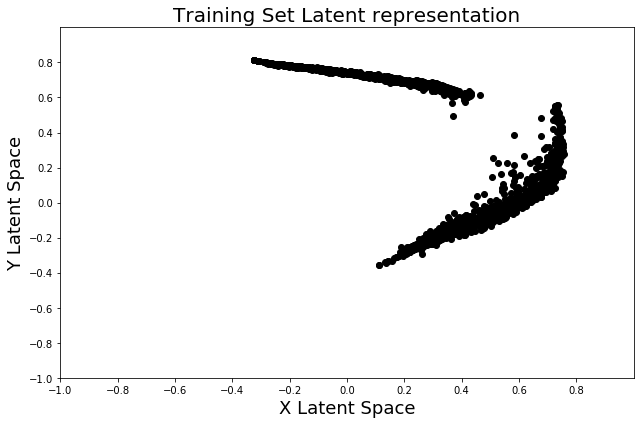

In [62]:
xtrain_latent = encoder_model.predict(X_train_mmsc)[:,0]
ytrain_latent = encoder_model.predict(X_train_mmsc)[:,1]

plot_encoder_net(xtrain_latent,ytrain_latent)


In the plot above we can distinguish two cluster:
Is reasonable to assume that the more homogeneous cluster contains the events related to the beam while the other one contains the events where a reaction has occurred. Let's use kMeans in the latent space in order to cluster data in our validation dataset and then let's look at the labels in order to make sure that our assumption above holds.

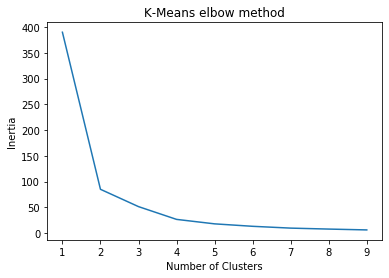

In [63]:
# Calculating Inertia for each K-Means with different number of clusters
encoder_pred_train = encoder_model.predict(X_train_mmsc)
encoder_pred_val = encoder_model.predict(X_val_mmsc)

from sklearn.cluster import KMeans
nr_clusters = range(1,10)
inertia = []

for k in nr_clusters:
    km = KMeans(n_clusters=k)
    km.fit(encoder_pred_train)
    inertia.append(km.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia') #sum of squared error
plt.title('K-Means elbow method')
plt.plot(nr_clusters,inertia)

fig.tight_layout()
plt.show()

In [64]:
# Training Clustering k-Means

#Trying multiple Kmeans with different number of clusters
AE_clust2 = KMeans(n_clusters=2, random_state=1).fit(encoder_pred_train)
AE_clust3 = KMeans(n_clusters=3, random_state=1).fit(encoder_pred_train)
AE_clust4 = KMeans(n_clusters=4, random_state=1).fit(encoder_pred_train)
AE_clust5 = KMeans(n_clusters=5, random_state=1).fit(encoder_pred_train)

# Using function best_3cl_km in helper_function.py
AEKM2_pred_train, AEKM2_pred_val, AE_assoc2 = best_cl_km(2, AE_clust2, encoder_pred_train, encoder_pred_val, Labels_train)
AEKM3_pred_train, AEKM3_pred_val, AE_assoc3 = best_cl_km(3, AE_clust3, encoder_pred_train, encoder_pred_val, Labels_train)
AEKM4_pred_train, AEKM4_pred_val, AE_assoc4 = best_cl_km(4, AE_clust4, encoder_pred_train, encoder_pred_val, Labels_train)
AEKM5_pred_train, AEKM5_pred_val, AE_assoc5 = best_cl_km(5, AE_clust5, encoder_pred_train, encoder_pred_val, Labels_train)

KMeans with 2 clusters performance:
Max accuracy obtained is 0.9969  using the combination number : 1
Combination 1 has the "Cluster to Lables" association = [(0, 0.0), (1, 1.0)]
----------------------------------------------------------
KMeans with 3 clusters performance:
Max accuracy obtained is 0.9969  using the combination number : 5
Combination 5 has the "Cluster to Lables" association = [(0, 1.0), (1, 0.0), (2, 1.0)]
----------------------------------------------------------
KMeans with 4 clusters performance:
Max accuracy obtained is 0.9969  using the combination number : 5
Combination 5 has the "Cluster to Lables" association = [(0, 0.0), (1, 1.0), (2, 0.0), (3, 1.0)]
----------------------------------------------------------
KMeans with 5 clusters performance:
Max accuracy obtained is 0.9969  using the combination number : 11
Combination 11 has the "Cluster to Lables" association = [(0, 0.0), (1, 1.0), (2, 0.0), (3, 1.0), (4, 1.0)]
---------------------------------------------

The result with number of clusters equal to 3 seems to give better results, we will plot the performance of this KMeans model.

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.69%
Precision : 99.38%
Recall    : 100.00%
F1-score  : 0.9969
MCC       : 0.9938


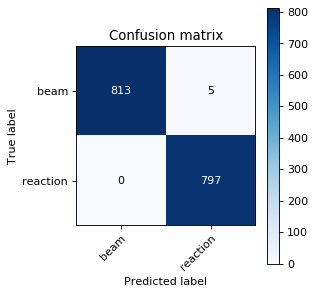


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 0.9946
MCC       : 0.9889


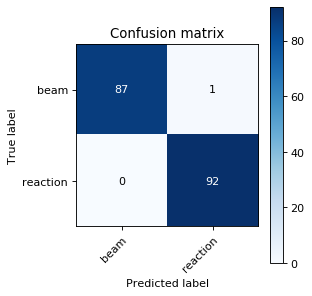

In [65]:
# Printing performances
print_model_performance(Labels_train,AEKM3_pred_train,"Training")
print_model_performance(Labels_val,AEKM3_pred_val,"Validation")

Let's visualize our train and validation set in Latent space: 

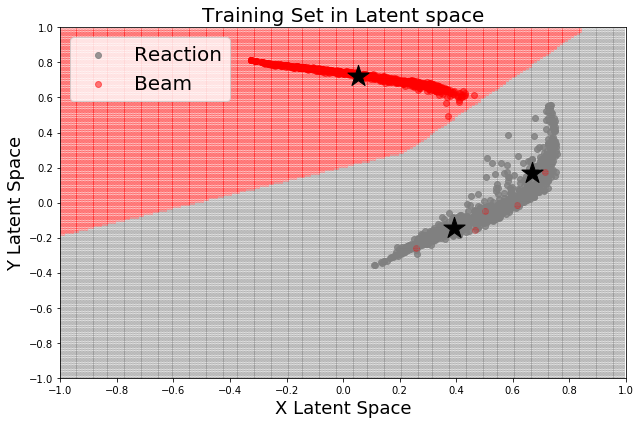

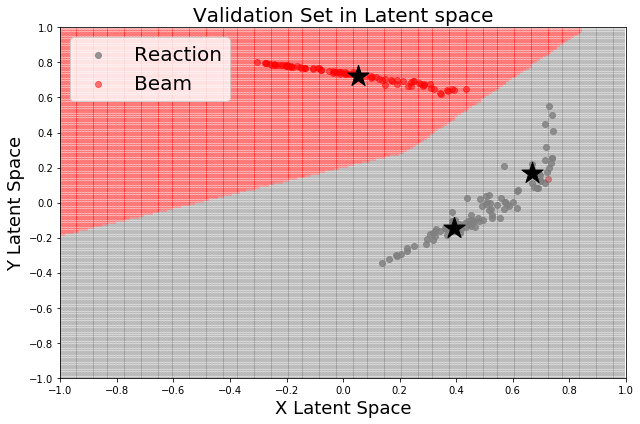

In [66]:
plot_kmeans_clustering(encoder_pred_train, Labels_train, AE_clust3, AE_assoc3, 'Training Set in Latent space')
plot_kmeans_clustering(encoder_pred_val, Labels_val, AE_clust3, AE_assoc3, 'Validation Set in Latent space')

#### Visualization of models using AutoEncoder
After the dimensionality reduction phase we can also use our labelled train set and classify it, in its new 2d representation, using other ML algorithms as seen above.

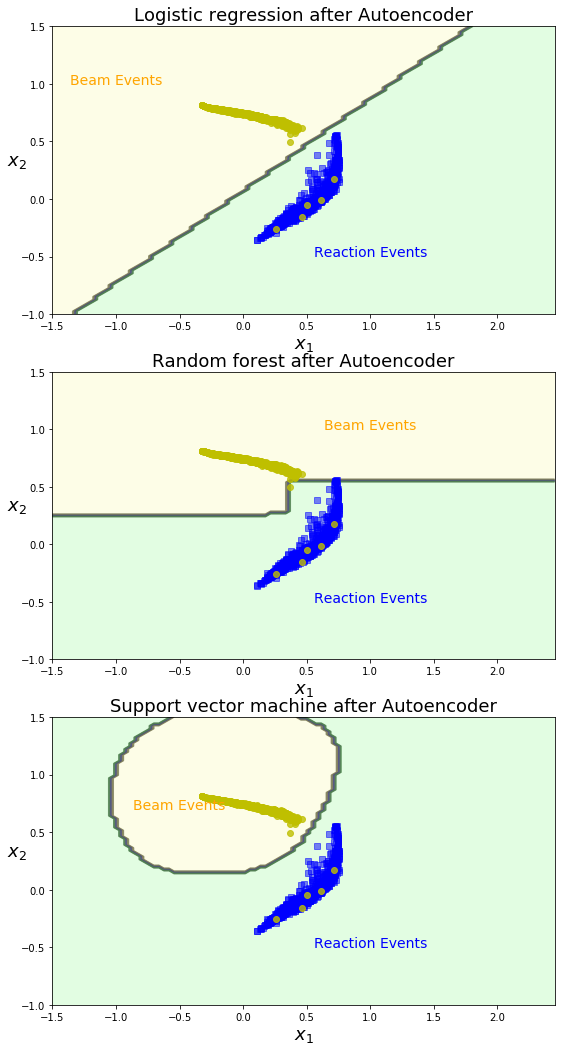

In [67]:
make_2d_vis_autoencoder(xtrain_latent, ytrain_latent, Labels_train)

##  <span style="color:darkred">Test Set Performance</span> 

After training and evaluation of the used ML methods, we now report the performance on the test set.
The first method used for this is the [voting classifier](#VotingClassifier) used above.

KMeans with 3 clusters performance:
Max accuracy obtained is 0.9963  using the combination number : 5
Combination 5 has the "Cluster to Lables" association = [(0, 1.0), (1, 0.0), (2, 1.0)]
----------------------------------------------------------
Model performance for test set:
--------------------------------------------------------
Accuracy  : 99.00%
Precision : 98.23%
Recall    : 100.00%
F1-score  : 0.9911
MCC       : 0.9799


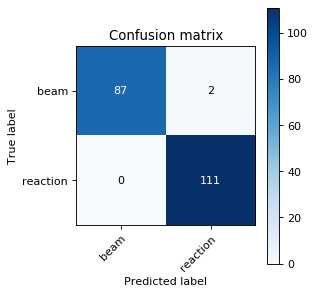

In [68]:

LR_pred_test = logreg2.predict(X_test_stdsc)
RFC_pred_test = RFC_best.predict(X_test_stdsc)
SVM_pred_test = SVM.predict(X_test_stdsc)

DNN_pred_test_pre = DNN_model.predict(X_test_stdsc)
DNN_pred_test = DNN_pred_test_pre > 0.5

not_used, KM3_pred_test, not_used2 = best_cl_km(3, KM_clust3, X_train_stdsc, X_test_stdsc, Labels_train)

Vote_pred_test = np.zeros(len(DNN_pred_test))
total_vote_test = np.zeros(len(DNN_pred_test))

for i in range(len(DNN_pred_test)):
    TotalVotesTest = DNN_pred_test[i] + KM3_pred_test[i] + LR_pred_test[i] + RFC_pred_test[i] + SVM_pred_test[i]
    total_vote_test[i] = TotalVotesTest
    if TotalVotesTest > 2:
        Vote_pred_test[i] = 1
    else:
        Vote_pred_test[i] = 0
        
print_model_performance(Labels_test,Vote_pred_test,"test")

The voting classifier performs well on the test set, with only 2 misclassified events. Similar to the training
and validation set performance, it misclassifies a few beam events as reaction events. 

# Conclusions